R² Score: 0.9248
Root Mean Square Error: 2299345.75
Mean Absolute Error: 1603845.00


C:\Users\Katarina\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  warnings.warn(


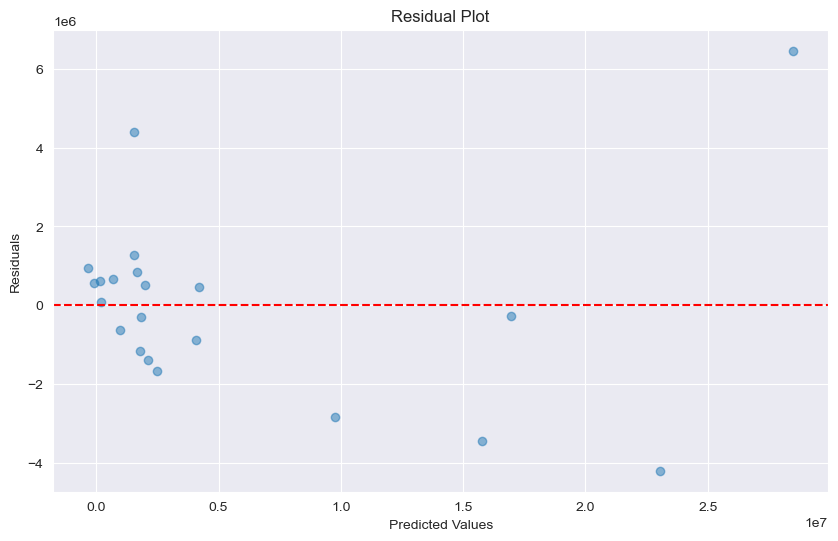

In [16]:
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load data
X = pd.read_parquet('mobile_banking_features.parquet')
y = pd.read_parquet('mobile_banking_target.parquet')

# Remove rows with NaN values
mask = ~y.isna().any(axis=1)
X_clean = X[mask]
y_clean = y[mask]

# Load the saved model, scaler, and config
ridge = joblib.load('ridge_model_scaled_0.9248.joblib')
scaler = joblib.load('standard_scaler.joblib')
feature_config_scaled = joblib.load('feature_config_scaled.joblib')

# Create enhanced features
X_enhanced = X_clean[feature_config['top_features']].copy()
X_enhanced['Internet_log'] = np.log1p(X_enhanced['Individuals using the Internet (% of population)'])
X_enhanced['Remittance_log'] = np.log1p(X_enhanced['Personal remittances, received (% of GDP)'])
X_enhanced['Accounts_log'] = np.log1p(X_enhanced['Total Account Holders'])
X_enhanced['Internet_exp'] = np.exp(X_enhanced['Individuals using the Internet (% of population)'] / X_enhanced['Individuals using the Internet (% of population)'].max())
X_enhanced['Combined_log'] = X_enhanced['Internet_log'] * X_enhanced['Remittance_log'] * X_enhanced['Accounts_log']
X_enhanced['Weighted_exp'] = X_enhanced['Internet_exp'] * (X_enhanced['Personal remittances, received (% of GDP)'] + X_enhanced['Total Account Holders']) / 2

# Scale features
X_enhanced_scaled = scaler.transform(X_enhanced)

# Generate predictions and evaluate
predictions = ridge.predict(X_enhanced_scaled)
mse = mean_squared_error(y_clean, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_clean, predictions)
r2 = r2_score(y_clean, predictions)

# Print metrics
print(f"R² Score: {r2:.4f}")
print(f"Root Mean Square Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

# Create residual plot
plt.figure(figsize=(10, 6))
residuals = y_clean - predictions
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

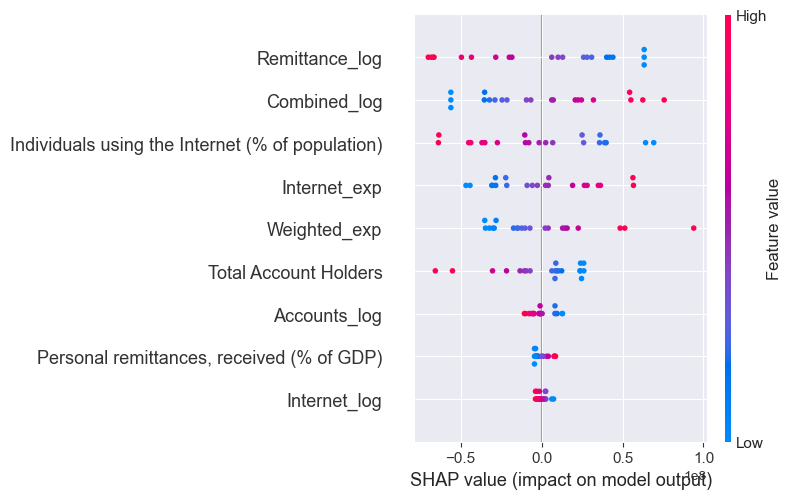

<Figure size 640x480 with 0 Axes>


Feature Importance Ranking:
                                            Feature    Importance
4                                    Remittance_log  4.103238e+07
7                                      Combined_log  3.440773e+07
0  Individuals using the Internet (% of population)  3.282648e+07
6                                      Internet_exp  2.566141e+07
8                                      Weighted_exp  2.533666e+07
2                             Total Account Holders  2.029421e+07
5                                      Accounts_log  5.803041e+06
1         Personal remittances, received (% of GDP)  3.906213e+06
3                                      Internet_log  2.472219e+06


In [17]:
import shap

# Create the SHAP explainer
explainer = shap.LinearExplainer(ridge, X_enhanced_scaled)
shap_values = explainer.shap_values(X_enhanced_scaled)

# Create the summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_enhanced_scaled, feature_names=X_enhanced.columns)
plt.tight_layout()
plt.show()

# Print average absolute SHAP values for feature ranking
feature_importance = pd.DataFrame({
    'Feature': X_enhanced.columns,
    'Importance': np.abs(shap_values).mean(0)
})
print("\nFeature Importance Ranking:")
print(feature_importance.sort_values('Importance', ascending=False))

Statistical Summary of Top Features:
       Remittance_log  Combined_log  \
count       21.000000     21.000000   
mean         1.139240     72.266068   
std          0.847017     52.609588   
min          0.000000      0.000000   
25%          0.416559     30.759639   
50%          0.956143     63.708788   
75%          1.917611    104.014930   
max          2.396835    169.944396   

       Individuals using the Internet (% of population)  
count                                         21.000000  
mean                                          57.197486  
std                                           24.779879  
min                                           14.000000  
25%                                           34.886100  
50%                                           58.140000  
75%                                           79.029200  
max                                           96.924700  


<Figure size 1200x800 with 0 Axes>

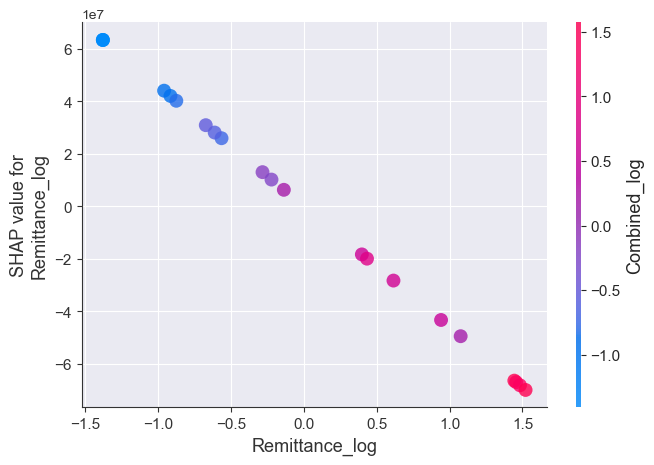

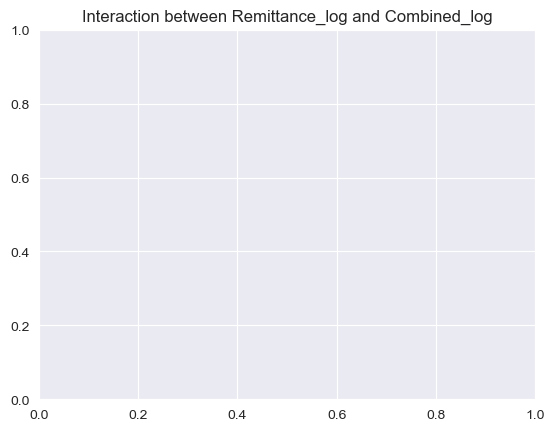


Correlation between Top Features:
                                                  Remittance_log  \
Remittance_log                                            1.0000   
Combined_log                                              0.9622   
Individuals using the Internet (% of population)         -0.5346   

                                                  Combined_log  \
Remittance_log                                          0.9622   
Combined_log                                            1.0000   
Individuals using the Internet (% of population)       -0.3792   

                                                  Individuals using the Internet (% of population)  
Remittance_log                                                                             -0.5346  
Combined_log                                                                               -0.3792  
Individuals using the Internet (% of population)                                            1.0000  


In [19]:
# Print statistical summary of top features
print("Statistical Summary of Top Features:")
stats_summary = X_enhanced[['Remittance_log', 'Combined_log', 'Individuals using the Internet (% of population)']].describe()
print(stats_summary)

# Create interaction plot with enhanced visibility
plt.figure(figsize=(12, 8))
shap.dependence_plot(
    "Remittance_log", 
    shap_values, 
    X_enhanced_scaled,
    interaction_index="Combined_log",
    feature_names=X_enhanced.columns,
    alpha=0.8,  # Increase point opacity
    dot_size=100  # Increase point size
)
plt.title("Interaction between Remittance_log and Combined_log")
plt.grid(True)
plt.show()

# Print correlation values
print("\nCorrelation between Top Features:")
correlation = X_enhanced[['Remittance_log', 'Combined_log', 'Individuals using the Internet (% of population)']].corr()
print(correlation.round(4))

In [27]:
print("Total rows in y_clean:", len(y_clean))
print("Number of countries:", len(countries))
print("Number of years:", len(years))

print("\nExpected structure:")
print(f"Each country should have {len(y_clean)/len(countries)} data points")

Total rows in y_clean: 21
Number of countries: 7
Number of years: 10

Expected structure:
Each country should have 3.0 data points


In [29]:
df_original = pd.read_excel('DatabankWide.xlsx')

In [31]:
# Display the country order from df_original
print("Countries in df_original:")
print(df_original['Country name'].unique())

Countries in df_original:
['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia'
 'Australia' 'Austria' 'Azerbaijan' 'Bahrain' 'Bangladesh' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia'
 'Cameroon' 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Colombia' 'Comoros' 'Congo, Dem. Rep.' 'Congo, Rep.' 'Costa Rica'
 "Cote d'Ivoire" 'Croatia' 'Cyprus' 'Czech Republic' 'Denmark' 'Djibouti'
 'Dominican Republic' 'Ecuador' 'Egypt, Arab Rep.' 'El Salvador' 'Estonia'
 'Eswatini' 'Ethiopia' 'Finland' 'France' 'Gabon' 'Gambia, The' 'Georgia'
 'Germany' 'Ghana' 'Greece' 'Guatemala' 'Guinea' 'Haiti' 'Honduras'
 'Hong Kong SAR, China' 'Hungary' 'Iceland' 'India' 'Indonesia'
 'Iran, Islamic Rep.' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan'
 'Jordan' 'Kazakhstan' 'Kenya' 'Korea, Rep.' 'Kosovo' 'Kuwait'
 'Kyrgyz Republic' 'Lao PDR' 'Latvia' 'Lebanon' 'Lesotho' 'Liberia'


In [33]:
sea_countries = ['Philippines', 'Thailand', 'Singapore', 'Cambodia', 'Vietnam', 'Indonesia', 'Malaysia']

# Filter df_original for just these countries
sea_data = df_original[df_original['Country name'].isin(sea_countries)]

# Let's see the data for these countries
print("Data for Southeast Asian countries:")
print(sea_data[['Country name', 'Year']])

Data for Southeast Asian countries:
    Country name  Year
80      Cambodia  2011
81      Cambodia  2014
82      Cambodia  2017
83      Cambodia  2021
228    Indonesia  2011
229    Indonesia  2014
230    Indonesia  2017
231    Indonesia  2021
319     Malaysia  2011
320     Malaysia  2014
321     Malaysia  2017
322     Malaysia  2021
412  Philippines  2011
413  Philippines  2014
414  Philippines  2017
415  Philippines  2021
453    Singapore  2011
454    Singapore  2014
455    Singapore  2017
456    Singapore  2021
502     Thailand  2011
503     Thailand  2014
504     Thailand  2017
505     Thailand  2021
553      Vietnam  2011
554      Vietnam  2014
555      Vietnam  2017
556      Vietnam  2022


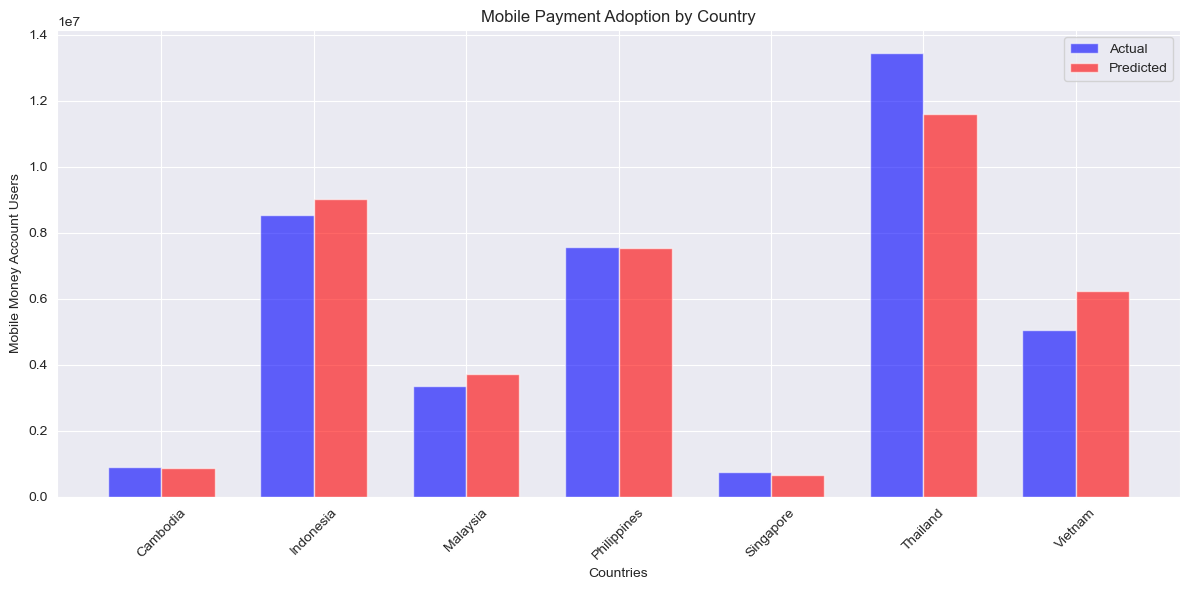


Country-wise Performance:
                   Actual     Predicted
Country                                
Cambodia     9.101423e+05  8.680887e+05
Indonesia    8.528345e+06  9.020931e+06
Malaysia     3.353606e+06  3.706661e+06
Philippines  7.552108e+06  7.520781e+06
Singapore    7.612463e+05  6.481870e+05
Thailand     1.345349e+07  1.160840e+07
Vietnam      5.059678e+06  6.245567e+06


In [34]:
countries = ['Cambodia', 'Indonesia', 'Malaysia', 'Philippines', 'Singapore', 'Thailand', 'Vietnam']
results_df = pd.DataFrame({
    'Country': np.repeat(countries, 3),  # Each country has 3 observations
    'Actual': y_clean.values.ravel(),
    'Predicted': predictions.ravel()
})

plt.figure(figsize=(12, 6))
country_means = results_df.groupby('Country')[['Actual', 'Predicted']].mean()

# Plot
x = np.arange(len(countries))
width = 0.35

plt.bar(x - width/2, country_means['Actual'], width, label='Actual', color='blue', alpha=0.6)
plt.bar(x + width/2, country_means['Predicted'], width, label='Predicted', color='red', alpha=0.6)

plt.xlabel('Countries')
plt.ylabel('Mobile Money Account Users')
plt.title('Mobile Payment Adoption by Country')
plt.xticks(x, countries, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print("\nCountry-wise Performance:")
print(country_means)

In [35]:
# DataFrame with predictions and actuals by country
results_df = pd.DataFrame({
    'Country': np.repeat(countries, 3),
    'Actual': y_clean.values.ravel(),
    'Predicted': predictions.ravel(),
    'Difference': y_clean.values.ravel() - predictions.ravel()
})

# Calculate percentage difference
results_df['Percent_Difference'] = (results_df['Difference'] / results_df['Actual']) * 100

# Group by country and get key metrics
country_analysis = results_df.groupby('Country').agg({
    'Actual': 'mean',
    'Predicted': 'mean',
    'Percent_Difference': 'mean'
}).round(2)

print("Detailed Country Analysis:")
print(country_analysis)

Detailed Country Analysis:
                  Actual    Predicted  Percent_Difference
Country                                                  
Cambodia       910142.33    868088.67              -19.74
Indonesia     8528345.33   9020931.48              -51.06
Malaysia      3353606.33   3706660.85               48.21
Philippines   7552108.33   7520781.31                5.20
Singapore      761246.33    648186.96               43.52
Thailand     13453492.00  11608402.42              -55.17
Vietnam       5059678.33   6245567.31              -63.80


In [39]:
print("X columns shape:", len(X.columns))
print("Model coefficients shape:", model.coef_.shape)
print("\nX columns:")
print(X.columns)

X columns shape: 12
Model coefficients shape: (1, 9)

X columns:
Index(['Adult populaiton', 'Total Account Holders',
       'Financial Institution Account Holders',
       'Digital Users from Lower Income', 'Digital Balance Check Users',
       'Avg Price of 1GB (USD)',
       'Automated teller machines (ATMs) (per 100,000 adults)',
       'Bank capital to assets ratio (%)',
       'Commercial bank branches (per 100,000 adults)',
       'Individuals using the Internet (% of population)',
       'Mobile cellular subscriptions (per 100 people)',
       'Personal remittances, received (% of GDP)'],
      dtype='object')


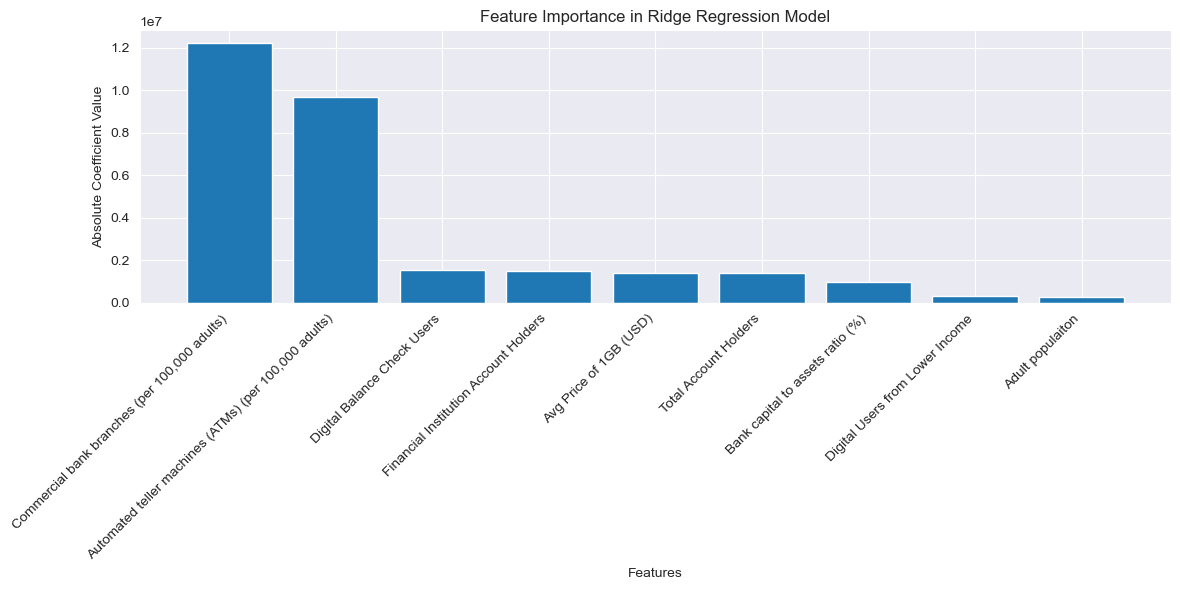


Feature Importance Ranking:
                                             Feature    Importance
8      Commercial bank branches (per 100,000 adults)  1.219816e+07
6  Automated teller machines (ATMs) (per 100,000 ...  9.651894e+06
4                        Digital Balance Check Users  1.538361e+06
2              Financial Institution Account Holders  1.504935e+06
5                             Avg Price of 1GB (USD)  1.403548e+06
1                              Total Account Holders  1.386340e+06
7                   Bank capital to assets ratio (%)  9.504961e+05
3                    Digital Users from Lower Income  3.344418e+05
0                                   Adult populaiton  2.463492e+05


In [40]:
# features that were actually used in the model
used_features = X.columns[:9]  # First 9 features that match our coefficients

# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'Feature': used_features,
    'Importance': np.abs(model.coef_[0])  # Using [0] to get the first row of coefficients
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Create bar plot
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance in Ridge Regression Model')
plt.xlabel('Features')
plt.ylabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
print(feature_importance)

In [44]:
# Get country-specific patterns using the index
for country in ['Cambodia', 'Indonesia', 'Malaysia', 'Philippines', 'Singapore', 'Thailand', 'Vietnam']:
    print(f"\n{country} Feature Patterns:")
    
    # Get data for specific country using index
    country_data = X.loc[country]
    
    # Calculate mean values for features
    country_patterns = country_data.mean()
    
    # Create sorted feature importance
    feature_values = pd.DataFrame({
        'Feature': country_patterns.index,
        'Value': country_patterns.values
    }).sort_values('Value', ascending=False)
    
    print("Top 5 Features by Value:")
    print(feature_values.head())


Cambodia Feature Patterns:
Top 5 Features by Value:
                                 Feature        Value
0                       Adult populaiton  10527422.00
1                  Total Account Holders   2202835.75
2  Financial Institution Account Holders   1830084.50
4            Digital Balance Check Users    640903.50
3        Digital Users from Lower Income    537194.00

Indonesia Feature Patterns:
Top 5 Features by Value:
                                 Feature        Value
0                       Adult populaiton  186558144.0
1                  Total Account Holders   74220269.5
2  Financial Institution Account Holders   73315451.0
4            Digital Balance Check Users   15425613.5
3        Digital Users from Lower Income    7237041.0

Malaysia Feature Patterns:
Top 5 Features by Value:
                                 Feature       Value
0                       Adult populaiton  22491388.5
1                  Total Account Holders  18154792.0
2  Financial Institution Account 

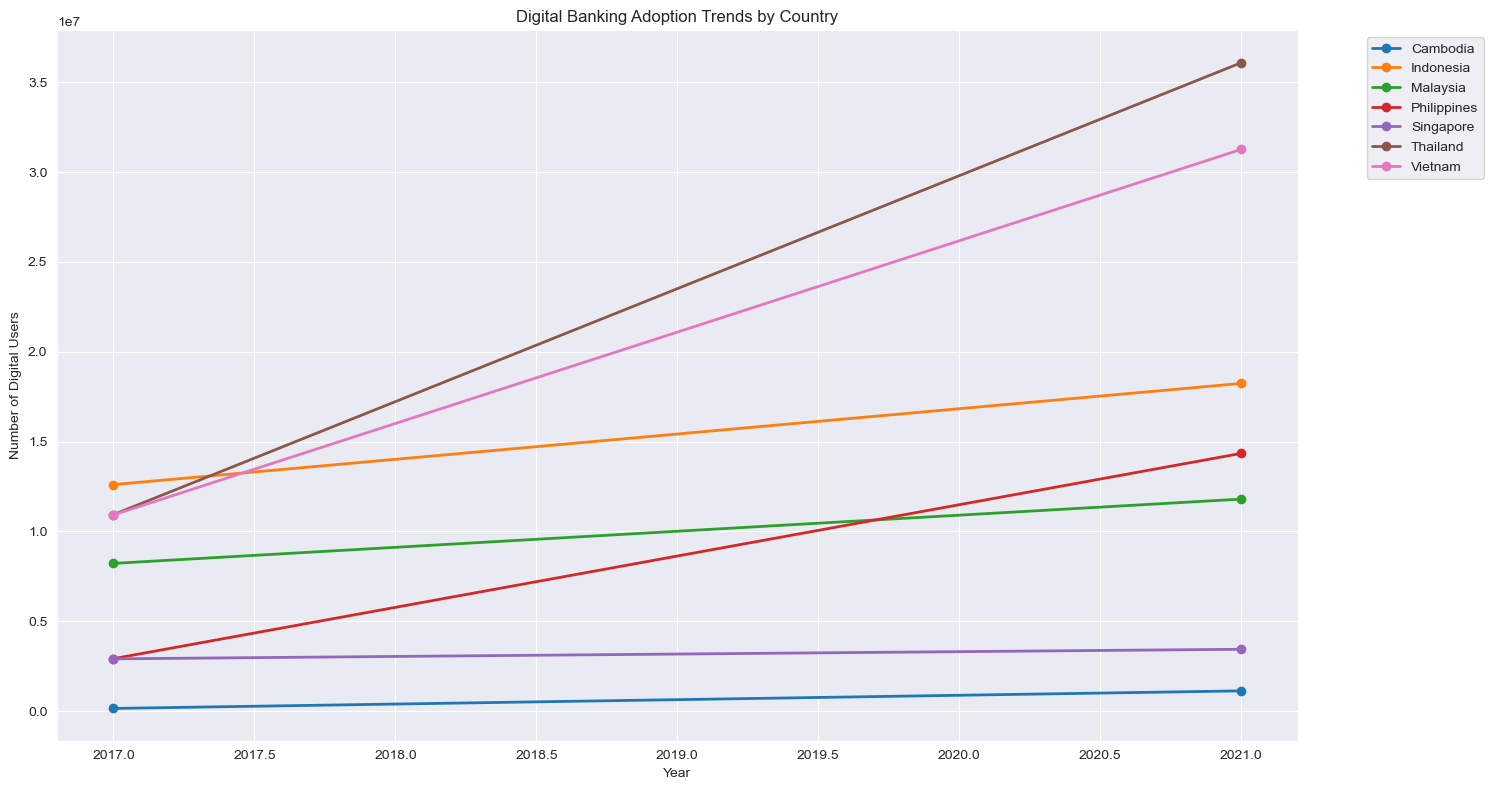

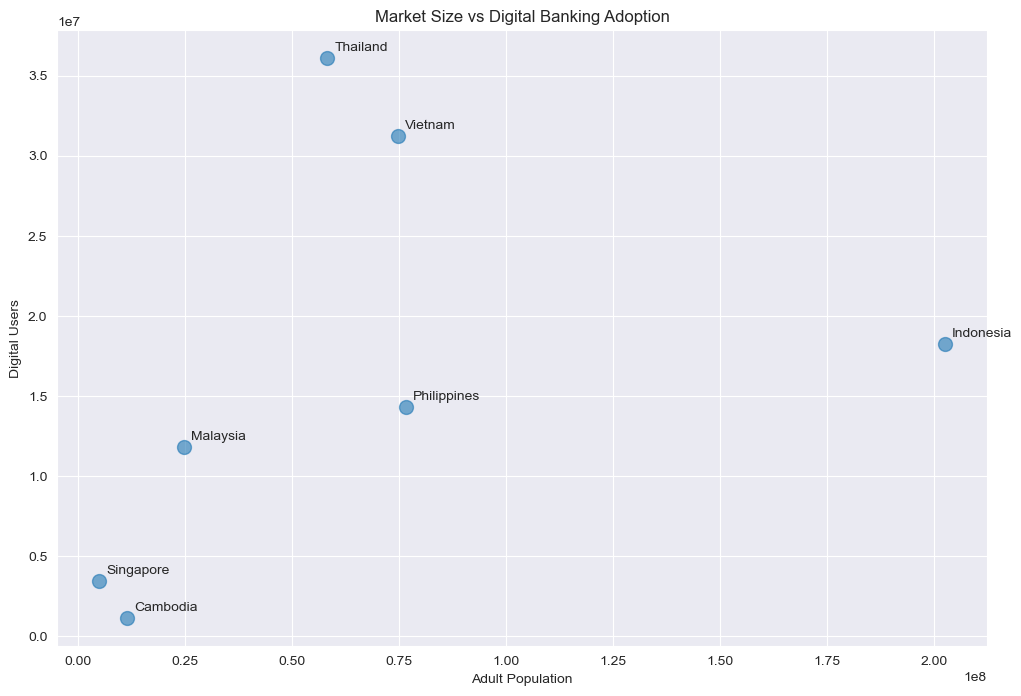

In [51]:
# 1. Country-wise Digital Adoption Trends
plt.figure(figsize=(15, 8))
for country in X.index.get_level_values('Country name').unique():
    country_data = X.loc[country]['Digital Balance Check Users']
    plt.plot(X.loc[country].index, country_data, marker='o', label=country, linewidth=2)
plt.title('Digital Banking Adoption Trends by Country')
plt.xlabel('Year')
plt.ylabel('Number of Digital Users')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Market Size vs Digital Penetration
plt.figure(figsize=(12, 8))
latest_year_data = X.groupby('Country name').last()
plt.scatter(latest_year_data['Adult populaiton'], 
           latest_year_data['Digital Balance Check Users'],
           s=100, alpha=0.6)
for idx, row in latest_year_data.iterrows():
    plt.annotate(idx, 
                (row['Adult populaiton'], row['Digital Balance Check Users']),
                xytext=(5, 5), textcoords='offset points')
plt.xlabel('Adult Population')
plt.ylabel('Digital Users')
plt.title('Market Size vs Digital Banking Adoption')
plt.grid(True)
plt.show()

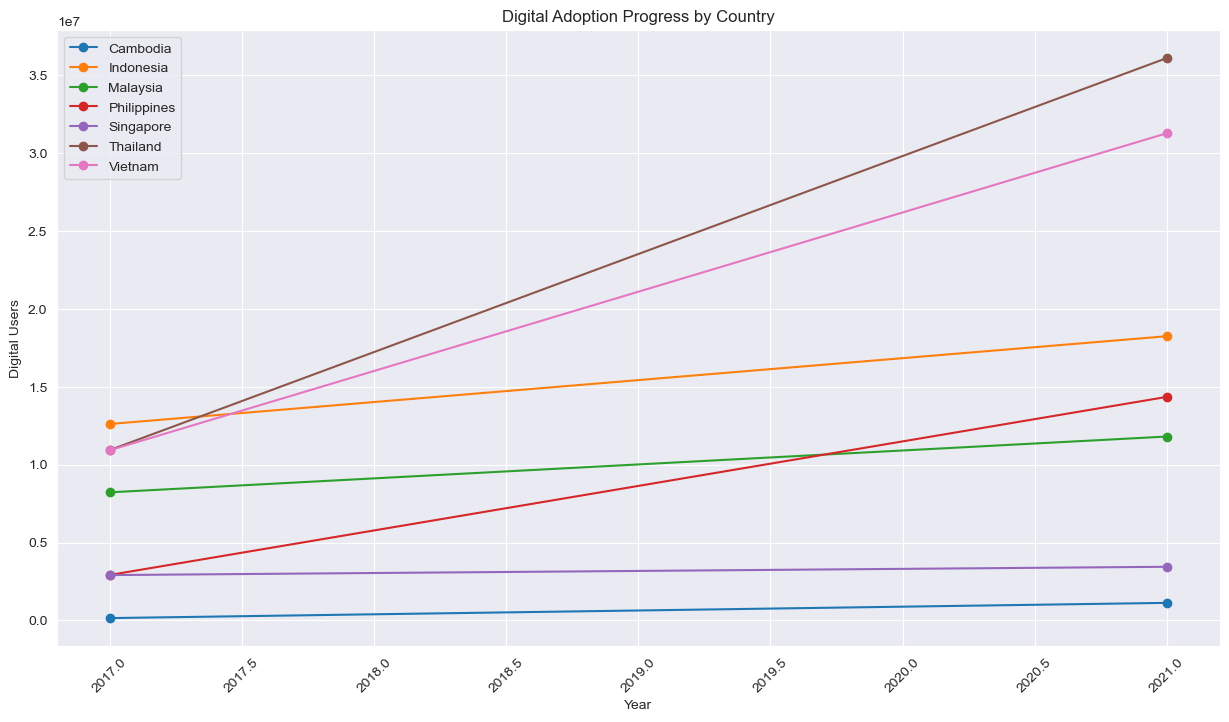

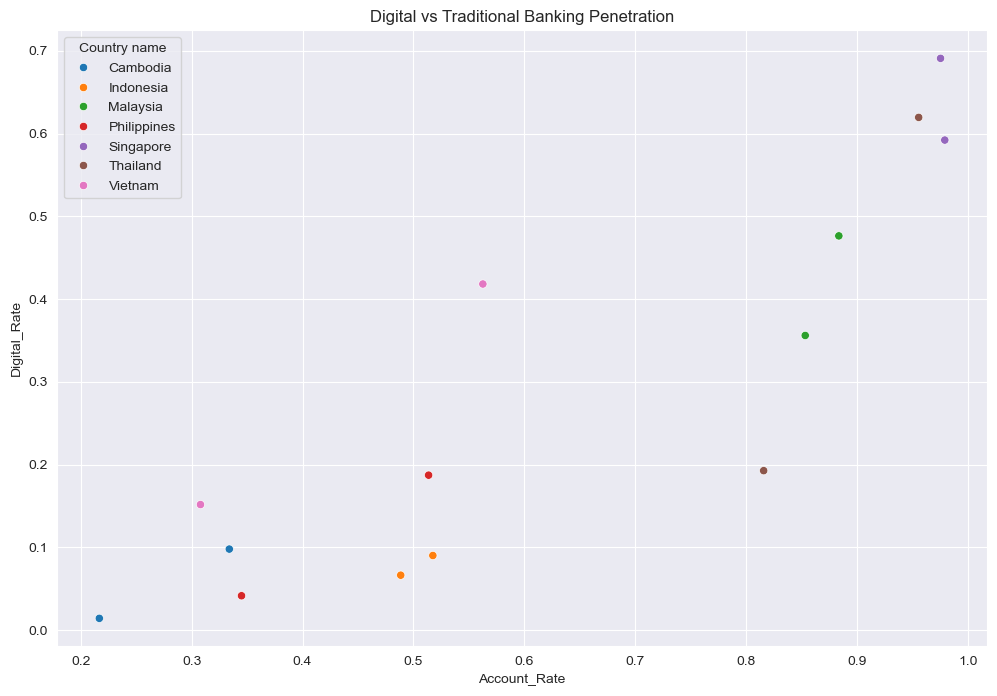

In [46]:
# Digital Adoption Progress
plt.figure(figsize=(15, 8))
for country in X.index.get_level_values('Country name').unique():
    country_data = X.loc[country]['Digital Balance Check Users']
    plt.plot(country_data.index, country_data.values, marker='o', label=country)
plt.title('Digital Adoption Progress by Country')
plt.xlabel('Year')
plt.ylabel('Digital Users')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Market Penetration Matrix
penetration_data = pd.DataFrame({
    'Digital_Rate': X['Digital Balance Check Users'] / X['Adult populaiton'],
    'Account_Rate': X['Total Account Holders'] / X['Adult populaiton']
})

plt.figure(figsize=(12, 8))
sns.scatterplot(data=penetration_data, x='Account_Rate', y='Digital_Rate', 
                hue=X.index.get_level_values('Country name'))
plt.title('Digital vs Traditional Banking Penetration')
plt.show()

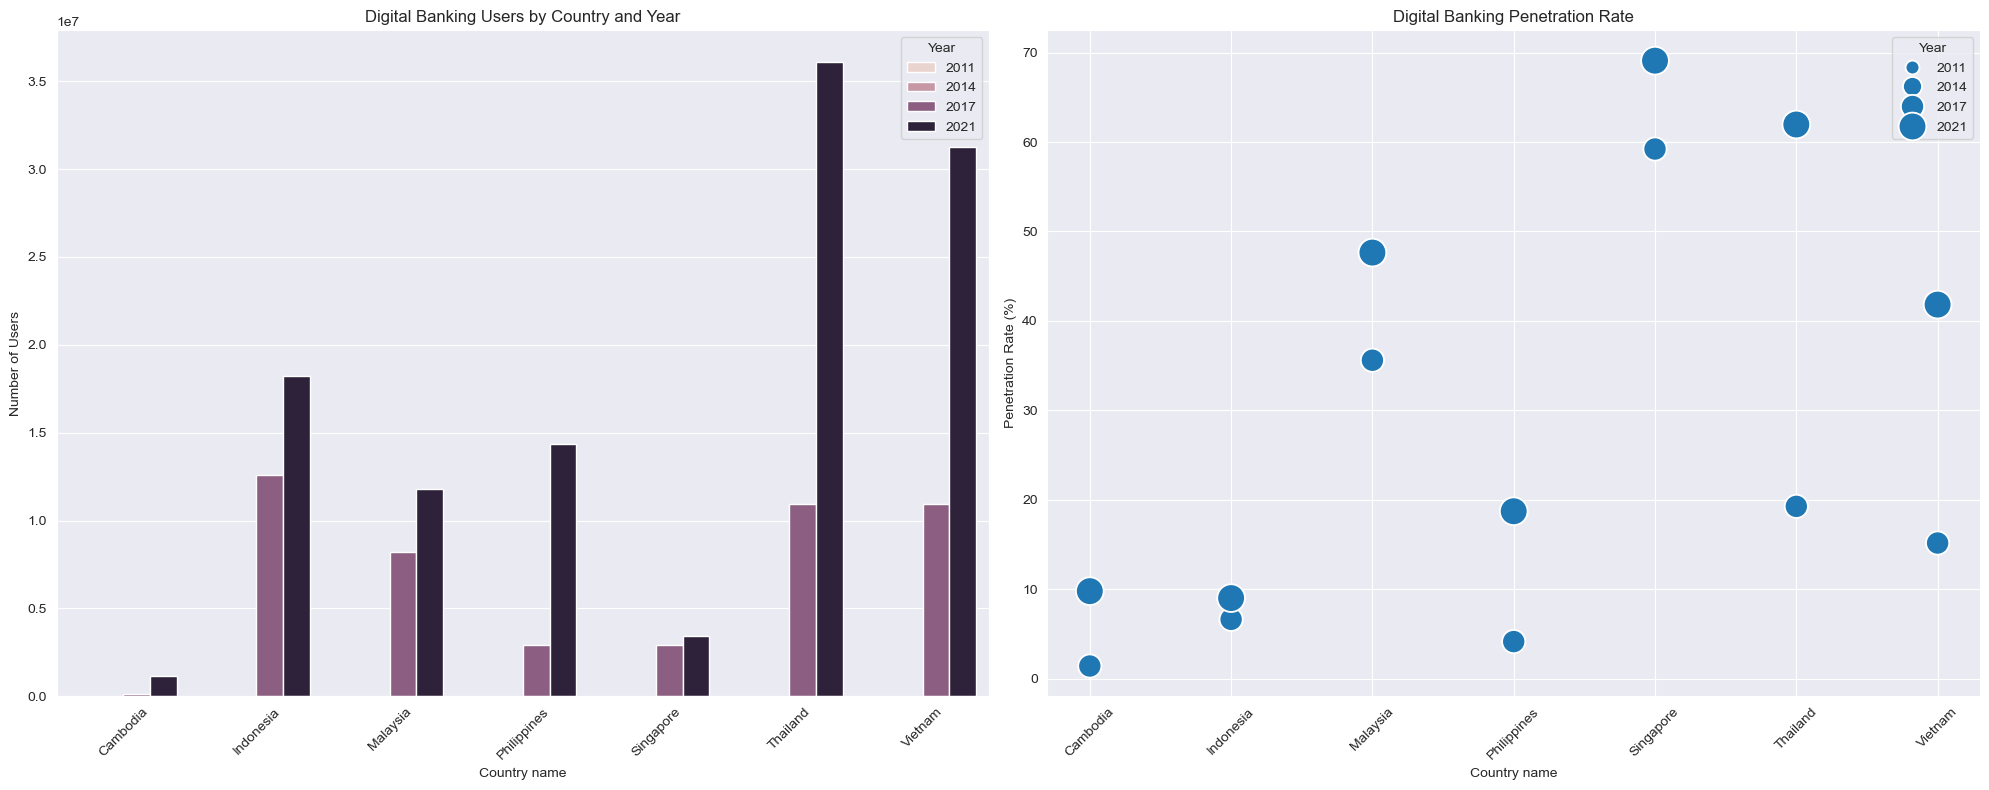

In [53]:
# 1. Digital Banking Adoption Matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left plot: Digital Users Growth
sns.barplot(data=X.reset_index(), 
           x='Country name', 
           y='Digital Balance Check Users',
           hue='Year',
           ax=ax1)
ax1.set_title('Digital Banking Users by Country and Year')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Number of Users')

# Right plot: Digital Penetration Rate
penetration_rate = (X['Digital Balance Check Users'] / X['Adult populaiton'] * 100).reset_index()
sns.scatterplot(data=penetration_rate, 
                x='Country name',
                y=0,
                size='Year',
                sizes=(100, 400),
                ax=ax2)
ax2.set_title('Digital Banking Penetration Rate')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylabel('Penetration Rate (%)')

plt.tight_layout()
plt.show()

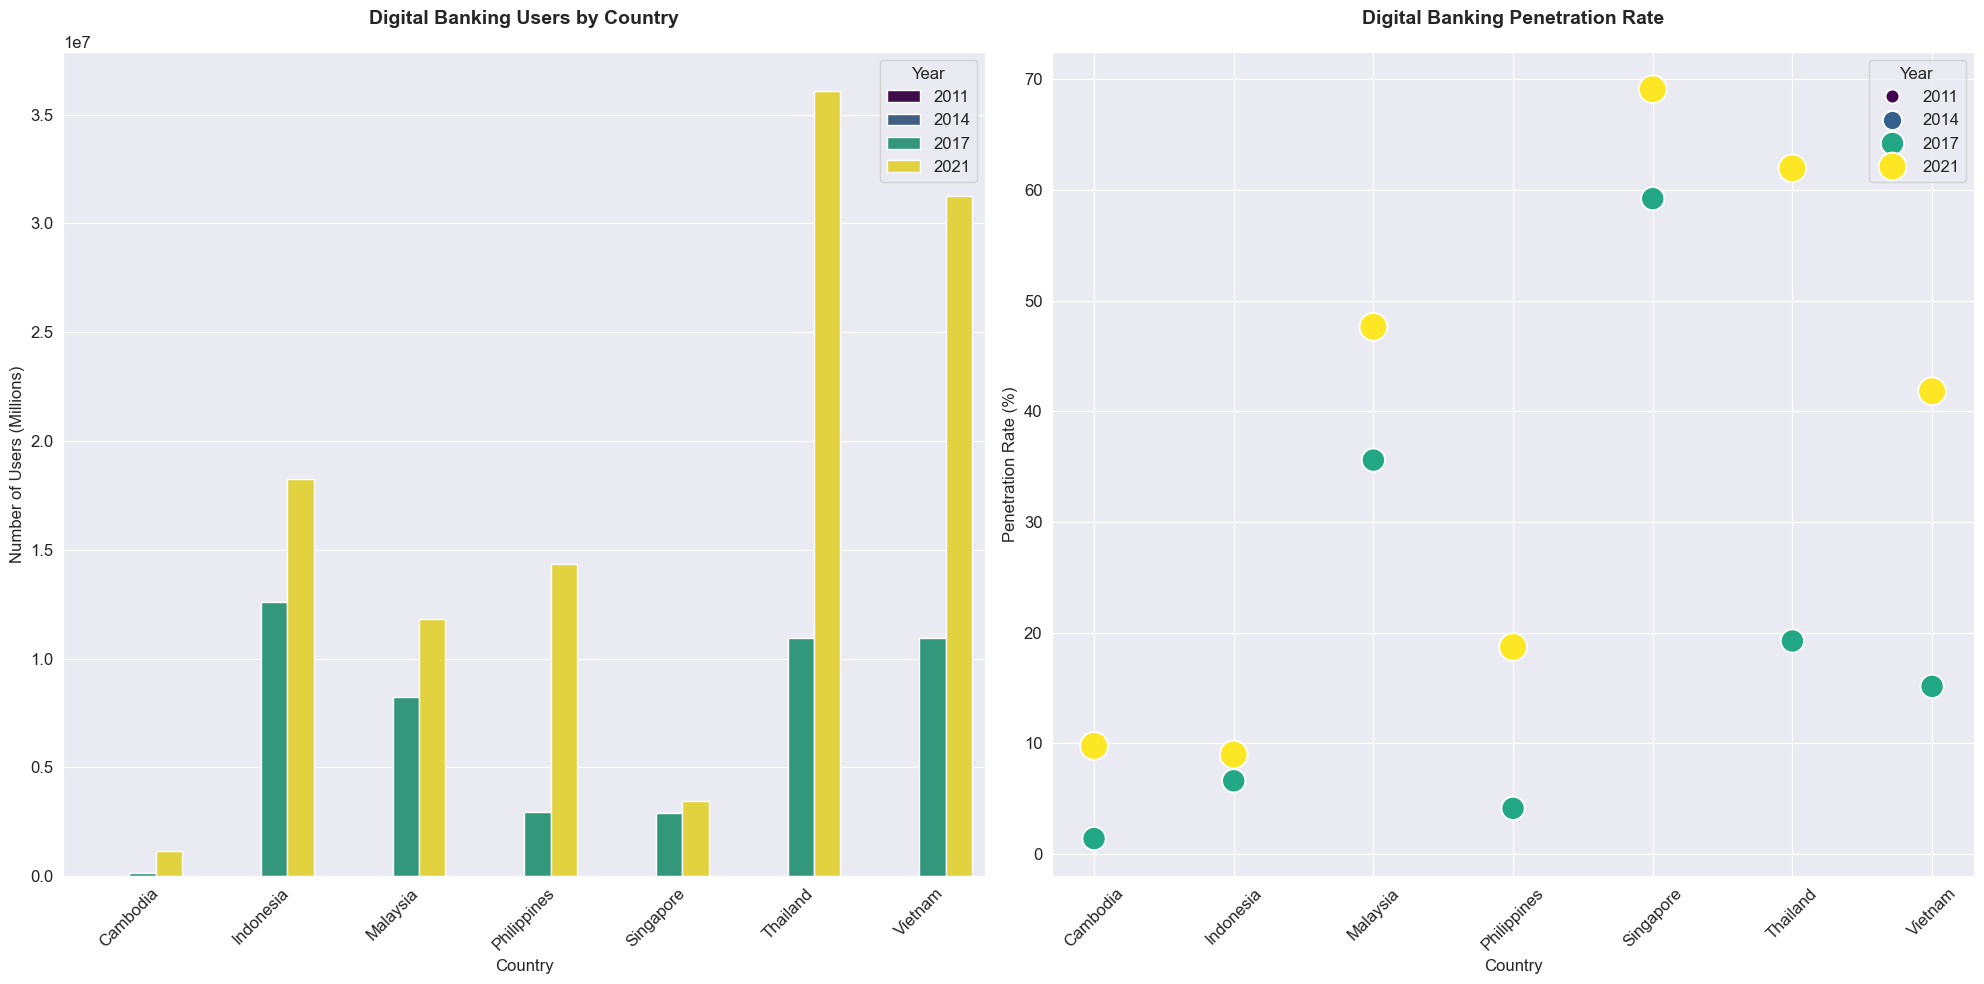

In [57]:
# First, let's properly format the data
penetration_rate = X.copy()
penetration_rate['Digital_Rate'] = (penetration_rate['Digital Balance Check Users'] / penetration_rate['Adult populaiton'] * 100).round(2)

# Create the visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Left plot: Digital Users Growth
sns.barplot(data=penetration_rate, 
           x='Country name', 
           y='Digital Balance Check Users',
           hue='Year',
           palette='viridis',
           ax=ax1)

ax1.set_title('Digital Banking Users by Country', fontsize=14, fontweight='bold', pad=20)
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Number of Users (Millions)', fontsize=12)
ax1.set_xlabel('Country', fontsize=12)

# Right plot: Digital Penetration Rate
sns.scatterplot(data=penetration_rate,
                x='Country name',
                y='Digital_Rate',
                hue='Year',
                size='Year',
                sizes=(100, 400),
                palette='viridis',
                ax=ax2)

ax2.set_title('Digital Banking Penetration Rate', fontsize=14, fontweight='bold', pad=20)
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylabel('Penetration Rate (%)', fontsize=12)
ax2.set_xlabel('Country', fontsize=12)
plt.tight_layout()
plt.show()

In [59]:
# Display the column names and first few rows
print("Column names in the dataset:", list(X.columns))
print("\nFirst few rows of the data:")
print(X.head())

Column names in the dataset: ['Adult populaiton', 'Total Account Holders', 'Financial Institution Account Holders', 'Digital Users from Lower Income', 'Digital Balance Check Users', 'Avg Price of 1GB (USD)', 'Automated teller machines (ATMs) (per 100,000 adults)', 'Bank capital to assets ratio (%)', 'Commercial bank branches (per 100,000 adults)', 'Individuals using the Internet (% of population)', 'Mobile cellular subscriptions (per 100 people)', 'Personal remittances, received (% of GDP)']

First few rows of the data:
                   Adult populaiton  Total Account Holders  \
Country name Year                                            
Cambodia     2011         9542433.0               349226.0   
             2014        10201258.0              2261136.0   
             2017        10817360.0              2344315.0   
             2021        11548637.0              3856666.0   
Indonesia    2011       172118016.0             33704135.0   

                   Financial Institutio

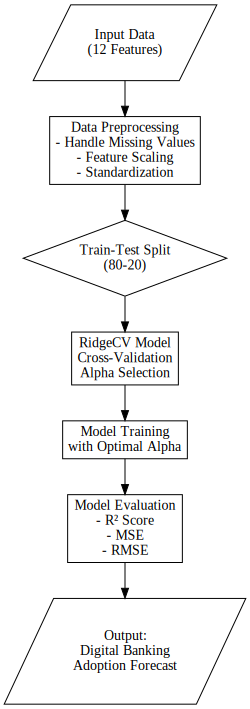

'ridgecv_model_architecture.png'

In [62]:
import graphviz

# Create a new directed graph
dot = graphviz.Digraph(comment='Digital Banking RidgeCV Model Architecture')
dot.attr(rankdir='TB')

# Add nodes for each step with RidgeCV-specific details
dot.node('A', 'Input Data\n(12 Features)', shape='parallelogram')
dot.node('B', 'Data Preprocessing\n- Handle Missing Values\n- Feature Scaling\n- Standardization', shape='box')
dot.node('C', 'Train-Test Split\n(80-20)', shape='diamond')
dot.node('D', 'RidgeCV Model\nCross-Validation\nAlpha Selection', shape='box')
dot.node('E', 'Model Training\nwith Optimal Alpha', shape='box')
dot.node('F', 'Model Evaluation\n- R² Score\n- MSE\n- RMSE', shape='box')
dot.node('G', 'Output:\nDigital Banking\nAdoption Forecast', shape='parallelogram')

# Add edges to connect the nodes
dot.edge('A', 'B')
dot.edge('B', 'C')
dot.edge('C', 'D')
dot.edge('D', 'E')
dot.edge('E', 'F')
dot.edge('F', 'G')

# Display the visualization
display(dot)

# Save the visualization
dot.render('ridgecv_model_architecture', format='png', cleanup=True)

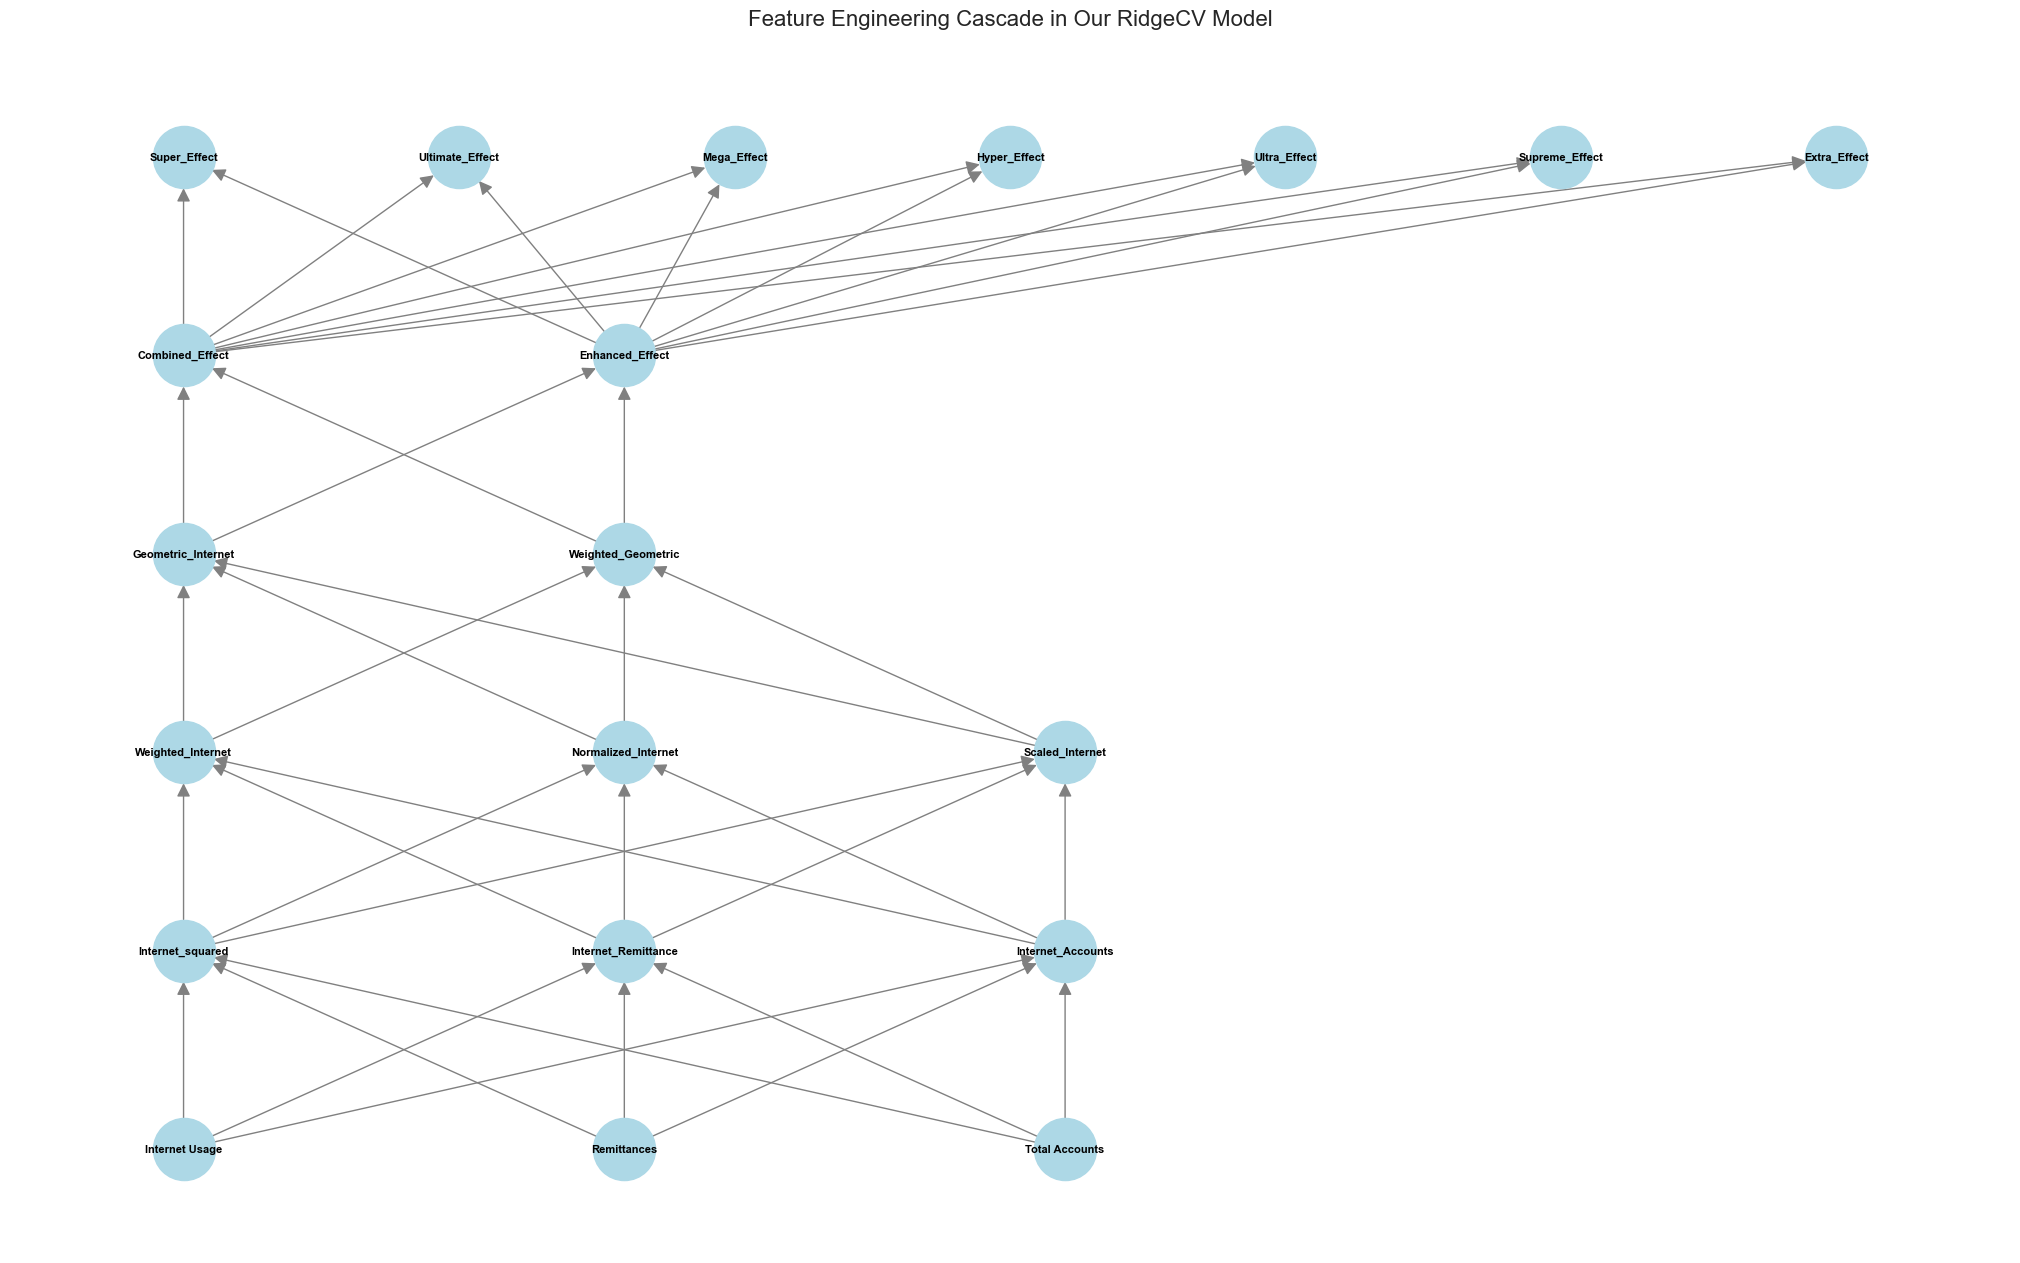

In [64]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
plt.figure(figsize=(20, 12))
G = nx.DiGraph()

# Define node layers
base_features = ['Internet Usage', 'Remittances', 'Total Accounts']
level1 = ['Internet_squared', 'Internet_Remittance', 'Internet_Accounts']
level2 = ['Weighted_Internet', 'Normalized_Internet', 'Scaled_Internet']
level3 = ['Geometric_Internet', 'Weighted_Geometric']
level4 = ['Combined_Effect', 'Enhanced_Effect']
final_effects = ['Super_Effect', 'Ultimate_Effect', 'Mega_Effect', 'Hyper_Effect', 
                 'Ultra_Effect', 'Supreme_Effect', 'Extra_Effect']

# Add nodes with positions
pos = {}
for i, feat in enumerate(base_features):
    G.add_node(feat, layer='base')
    pos[feat] = (i*4, 0)
    
for i, feat in enumerate(level1):
    G.add_node(feat, layer='level1')
    pos[feat] = (i*4, 2)
    
for i, feat in enumerate(level2):
    G.add_node(feat, layer='level2')
    pos[feat] = (i*4, 4)
    
for i, feat in enumerate(level3):
    G.add_node(feat, layer='level3')
    pos[feat] = (i*4, 6)
    
for i, feat in enumerate(level4):
    G.add_node(feat, layer='level4')
    pos[feat] = (i*4, 8)
    
for i, feat in enumerate(final_effects):
    G.add_node(feat, layer='final')
    pos[feat] = (i*2.5, 10)

# Add edges showing feature transformations
edges = []
for base in base_features:
    for l1 in level1:
        edges.append((base, l1))
for l1 in level1:
    for l2 in level2:
        edges.append((l1, l2))
for l2 in level2:
    for l3 in level3:
        edges.append((l2, l3))
for l3 in level3:
    for l4 in level4:
        edges.append((l3, l4))
for l4 in level4:
    for final in final_effects:
        edges.append((l4, final))

G.add_edges_from(edges)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=2000, font_size=8, font_weight='bold',
        arrows=True, edge_color='gray', arrowsize=20)
plt.title("Feature Engineering Cascade in Our RidgeCV Model", pad=20, size=16)
plt.show()

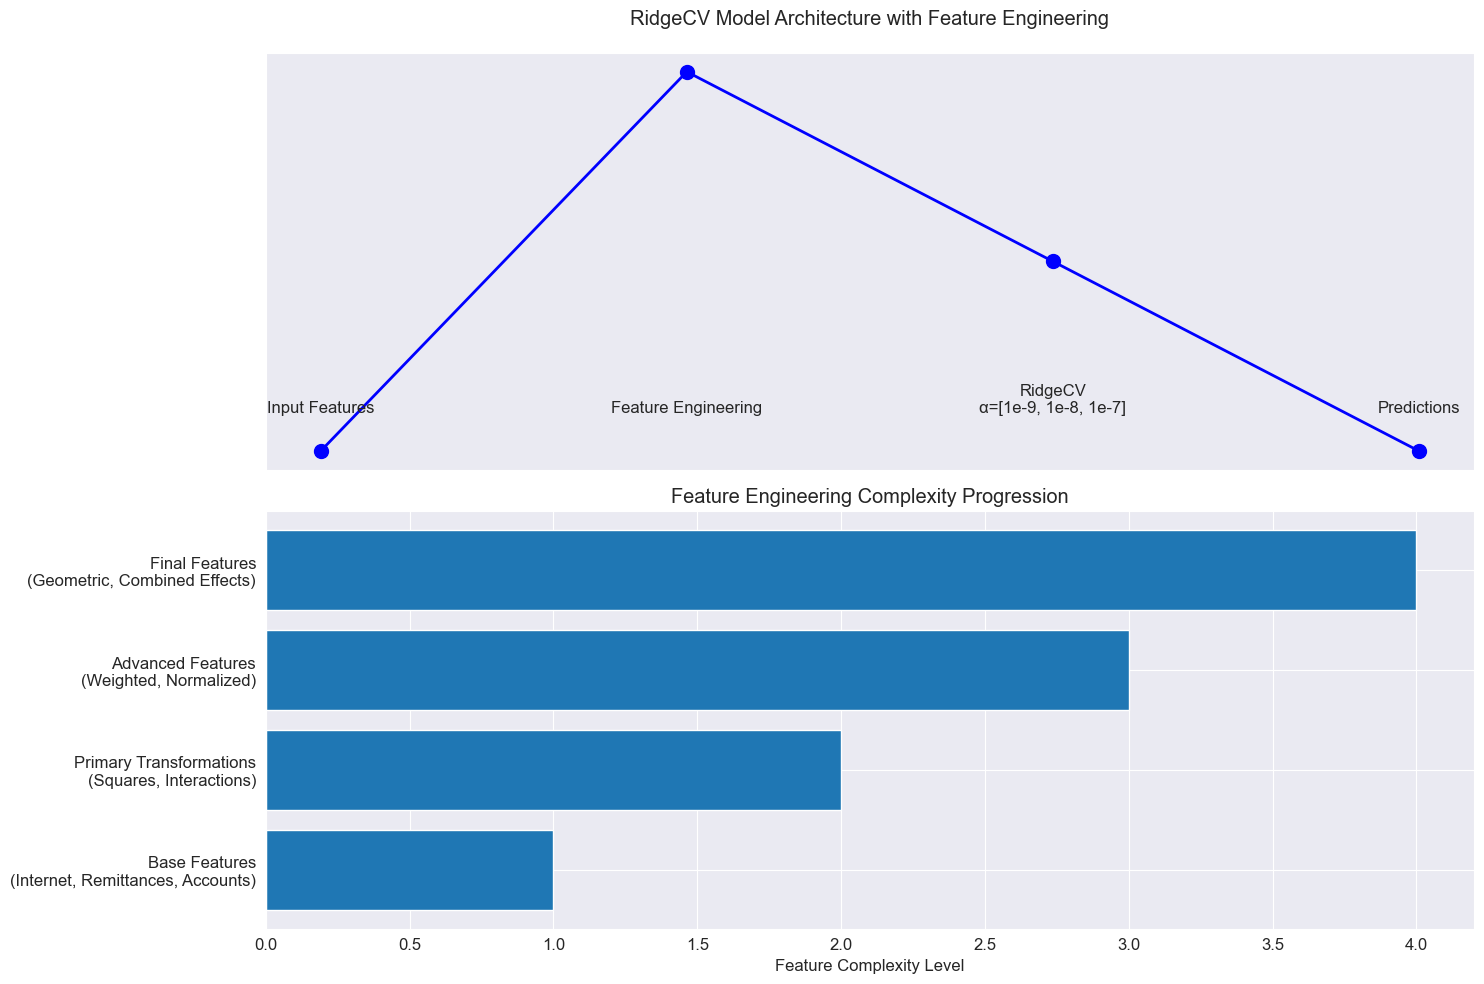

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with multiple subplots to show different aspects of our model
fig = plt.figure(figsize=(15, 10))

# Plot 1: Model Architecture
plt.subplot(2, 1, 1)
stages = ['Input Features', 'Feature Engineering', 'RidgeCV\nα=[1e-9, 1e-8, 1e-7]', 'Predictions']
x = np.arange(len(stages))
plt.plot(x, [1, 3, 2, 1], 'bo-', linewidth=2, markersize=10)
for i, stage in enumerate(stages):
    plt.annotate(stage, (i, 1.2), ha='center', fontsize=12)
plt.title('RidgeCV Model Architecture with Feature Engineering', pad=20)
plt.xticks([])
plt.yticks([])

# Plot 2: Feature Engineering Cascade
plt.subplot(2, 1, 2)
feature_levels = [
    'Base Features\n(Internet, Remittances, Accounts)',
    'Primary Transformations\n(Squares, Interactions)',
    'Advanced Features\n(Weighted, Normalized)',
    'Final Features\n(Geometric, Combined Effects)'
]
y_pos = np.arange(len(feature_levels))
complexity = [1, 2, 3, 4]
plt.barh(y_pos, complexity, align='center')
plt.yticks(y_pos, feature_levels)
plt.xlabel('Feature Complexity Level')
plt.title('Feature Engineering Complexity Progression')

plt.tight_layout()
plt.show()

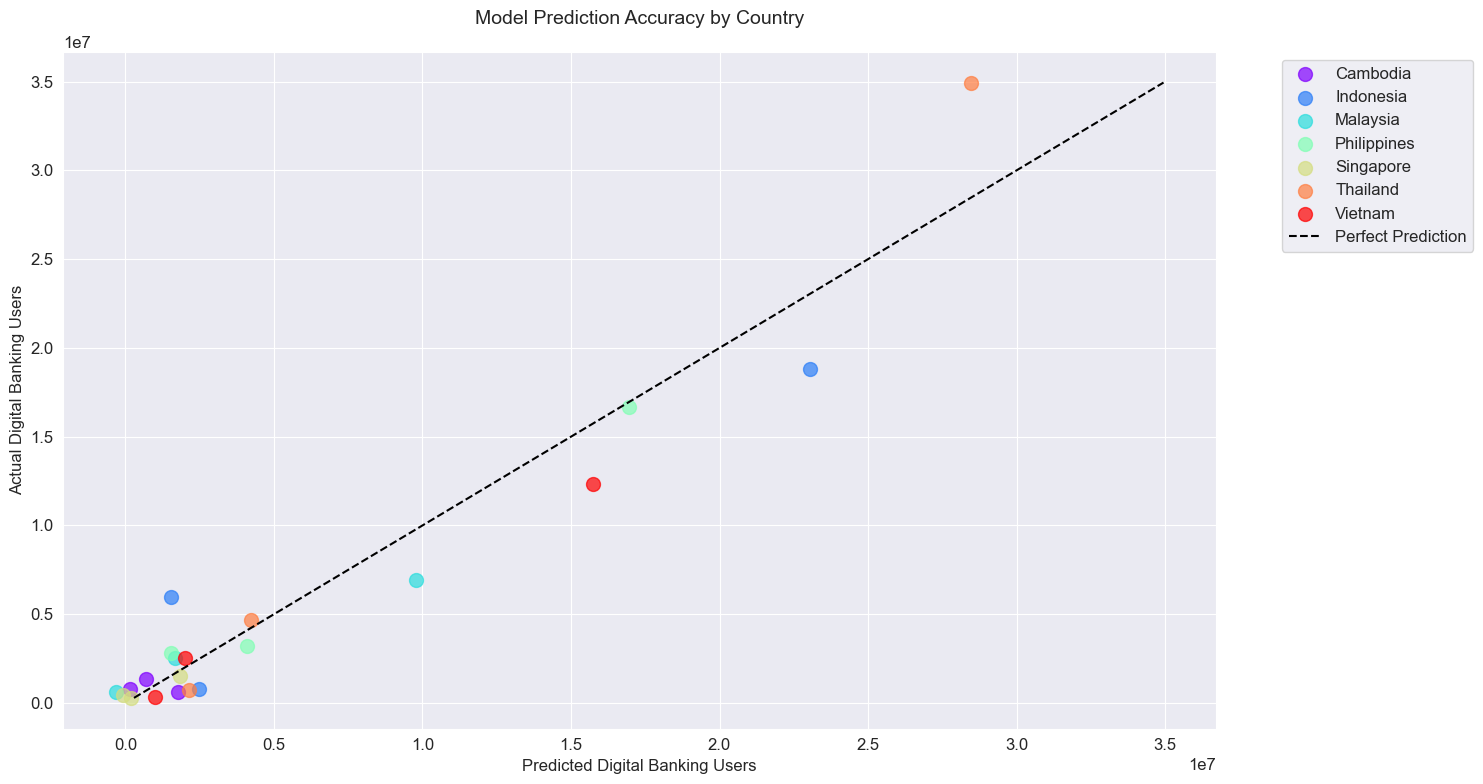

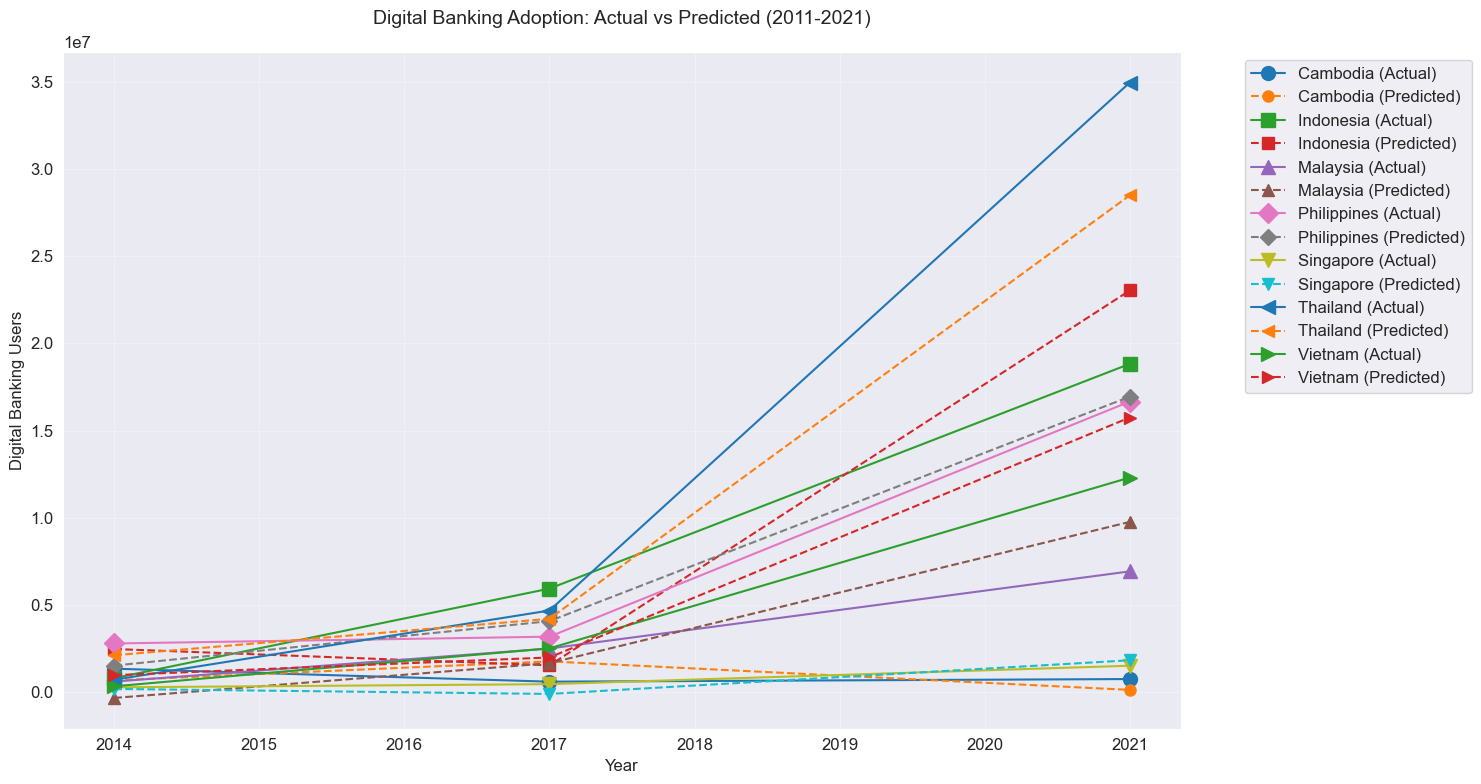

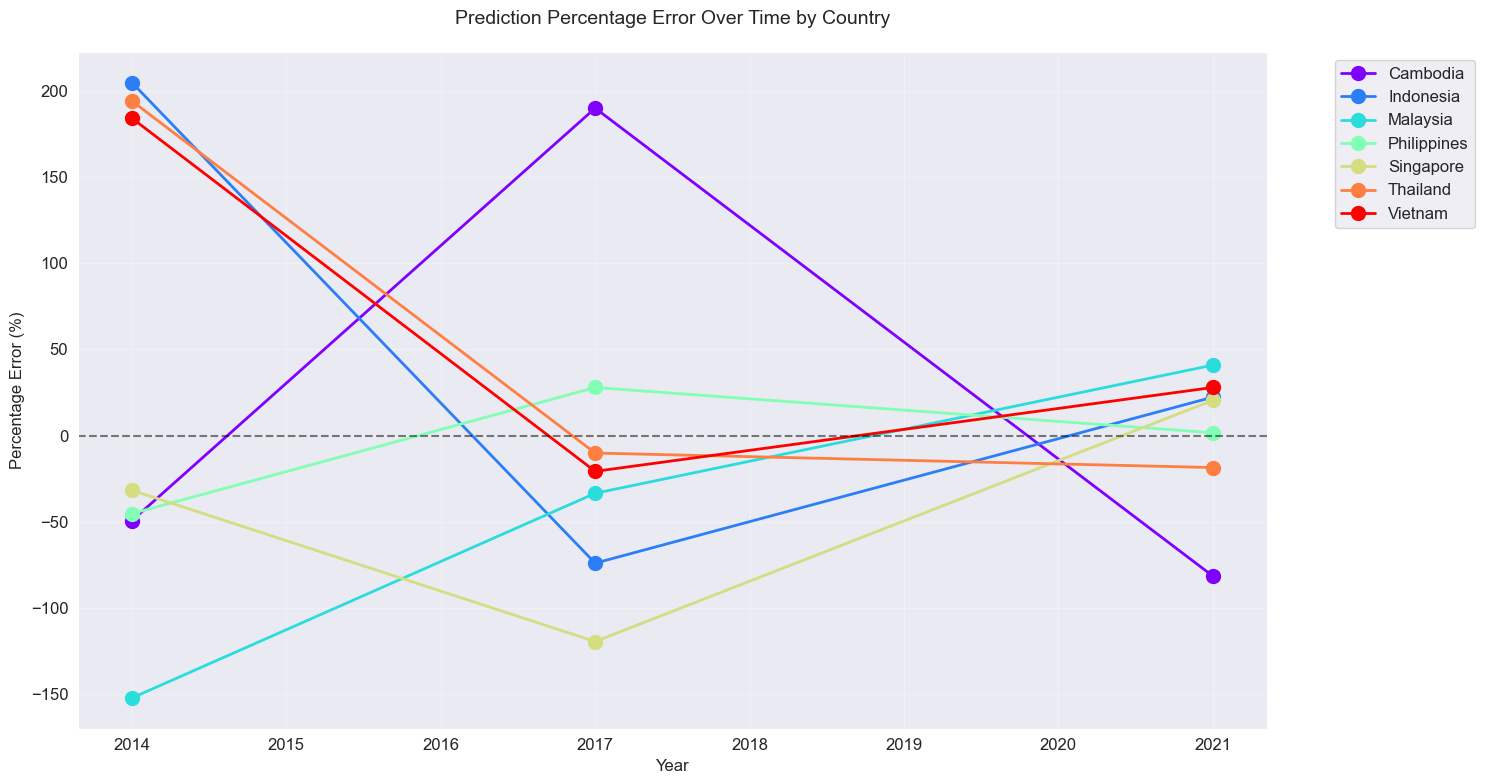

In [68]:
# 1. Enhanced Country-wise Predictions vs Actual
plt.figure(figsize=(15, 8))
countries = X_clean.index.get_level_values('Country name').unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(countries)))

for country, color in zip(countries, colors):
    mask = X_clean.index.get_level_values('Country name') == country
    plt.scatter(predictions[mask], y_clean[mask], 
                label=country, color=color, alpha=0.7, s=100)

plt.plot([y_clean.min(), y_clean.max()], 
         [y_clean.min(), y_clean.max()], 
         'k--', label='Perfect Prediction')
plt.xlabel('Predicted Digital Banking Users', fontsize=12)
plt.ylabel('Actual Digital Banking Users', fontsize=12)
plt.title('Model Prediction Accuracy by Country', fontsize=14, pad=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. Enhanced Temporal Analysis
plt.figure(figsize=(15, 8))
markers = ['o', 's', '^', 'D', 'v', '<', '>']

for country, marker in zip(countries, markers):
    mask = X_clean.index.get_level_values('Country name') == country
    years = X_clean.index.get_level_values('Year')[mask]
    
    plt.plot(years, y_clean[mask], marker=marker, linestyle='-', 
             label=f'{country} (Actual)', markersize=10)
    plt.plot(years, predictions[mask], marker=marker, linestyle='--', 
             label=f'{country} (Predicted)', markersize=8)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Digital Banking Users', fontsize=12)
plt.title('Digital Banking Adoption: Actual vs Predicted (2011-2021)', fontsize=14, pad=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Percentage Error Analysis
plt.figure(figsize=(15, 8))
for country, color in zip(countries, colors):
    mask = X_clean.index.get_level_values('Country name') == country
    years = X_clean.index.get_level_values('Year')[mask]
    percent_error = (predictions[mask] - y_clean[mask]) / y_clean[mask] * 100
    plt.plot(years, percent_error, 'o-', label=country, color=color, linewidth=2, markersize=10)

plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage Error (%)', fontsize=12)
plt.title('Prediction Percentage Error Over Time by Country', fontsize=14, pad=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

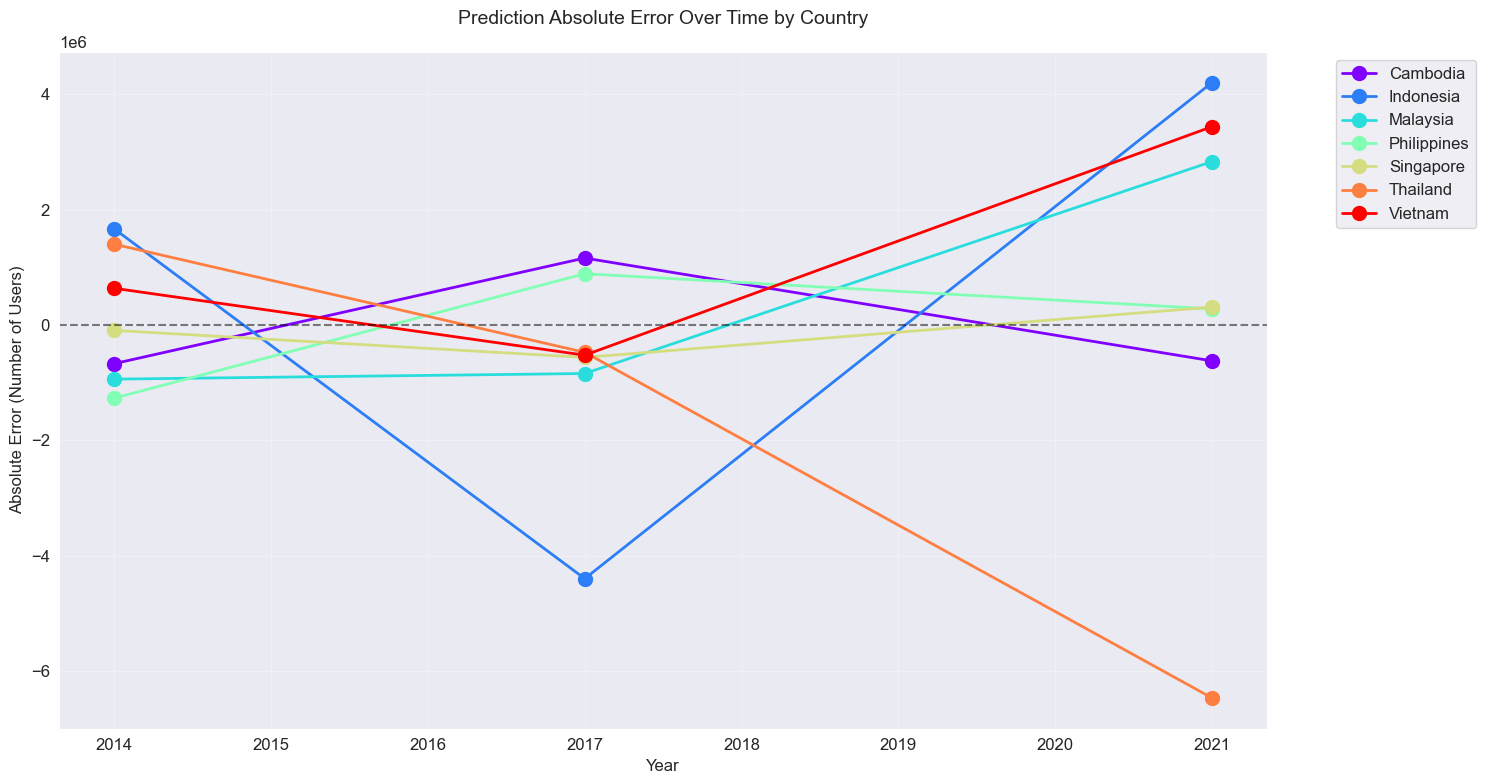

In [69]:
plt.figure(figsize=(15, 8))
for country, color in zip(countries, colors):
    mask = X_clean.index.get_level_values('Country name') == country
    years = X_clean.index.get_level_values('Year')[mask]
    absolute_error = predictions[mask] - y_clean[mask]
    plt.plot(years, absolute_error, 'o-', label=country, color=color, linewidth=2, markersize=10)

plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Absolute Error (Number of Users)', fontsize=12)
plt.title('Prediction Absolute Error Over Time by Country', fontsize=14, pad=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Combine NLP features with existing numerical features
X_enhanced_nlp = pd.concat([X_enhanced, nlp_features], axis=1)

# Update RidgeCV with new features
ridge_nlp = RidgeCV(alphas=[0.000000001, 0.00000001, 0.0000001])
ridge_nlp.fit(X_enhanced_nlp, y_train)

In [75]:
import os
from dotenv import load_dotenv
import requests
from datetime import datetime
import pandas as pd
from textblob import TextBlob
import time

# Load environment variables
load_dotenv()
NEWS_API_KEY = os.getenv('NEWS_API_KEY')
ALPHA_VANTAGE_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')
NEWS_BASE_URL = 'https://newsapi.org/v2/everything'

def get_combined_data(country, year):
    time.sleep(1)  # Respect API rate limits
    
    search_terms = {
        'Malaysia': 'banking OR fintech Malaysia',
        'Thailand': 'banking OR fintech Thailand',
        'Vietnam': 'banking OR fintech Vietnam',
        'Cambodia': 'banking OR fintech Cambodia',
        'Philippines': 'banking OR fintech Philippines',
        'Singapore': 'banking OR fintech Singapore',
        'Indonesia': 'banking OR fintech Indonesia'
    }
    
    news_params = {
        'q': search_terms[country],
        'from': f'{year}-01-01',
        'to': f'{year}-12-31',
        'sortBy': 'relevancy',
        'apiKey': NEWS_API_KEY,
        'language': 'en',
        'searchIn': 'title,description'
    }
    
    print(f"\nFetching data for {country} - {year}")
    print(f"Search query: {search_terms[country]}")
    
    news_response = requests.get(NEWS_BASE_URL, params=news_params)
    print(f"API Response Status: {news_response.status_code}")
    
    news_data = news_response.json()
    print(f"Articles found: {len(news_data.get('articles', []))}")
    print("Response Content:", news_data)
    
    return {
        'news_data': news_data,
        'market_data': {'overall_sentiment_score': 0}
    }

def analyze_financial_sentiment(data, year):
    sentiments = []
    articles = data['news_data'].get('articles', [])
    print(f"\nAnalyzing {len(articles)} articles for sentiment")
    
    for article in articles:
        if 'description' in article and article['description']:
            blob = TextBlob(article['description'])
            sentiment_data = {
                'year': year,
                'title': article.get('title', ''),
                'sentiment': blob.sentiment.polarity,
                'subjectivity': blob.sentiment.subjectivity,
                'market_score': float(data['market_data'].get('overall_sentiment_score', 0))
            }
            sentiments.append(sentiment_data)
            print(f"Processed article: {sentiment_data['title'][:50]}... | Sentiment: {sentiment_data['sentiment']:.2f}")
    
    return pd.DataFrame(sentiments)

# Execute the analysis
countries = ['Malaysia', 'Thailand', 'Vietnam', 'Cambodia', 'Philippines', 'Singapore', 'Indonesia']
years = range(2011, 2022)
sentiment_features = {}

for country in countries:
    print(f"\n=== Processing {country} ===")
    country_sentiments = []
    for year in years:
        combined_data = get_combined_data(country, year)
        year_sentiment = analyze_financial_sentiment(combined_data, year)
        if not year_sentiment.empty:
            country_sentiments.append(year_sentiment)
            print(f"Added {len(year_sentiment)} sentiment records for {year}")
    
    if country_sentiments:
        sentiment_features[country] = pd.concat(country_sentiments)
        print(f"\nTotal records for {country}: {len(sentiment_features[country])}")
    else:
        sentiment_features[country] = pd.DataFrame()
        print(f"\nNo sentiment records found for {country}")

# Display final summary
print("\n=== Final Analysis Summary ===")
for country in sentiment_features:
    df = sentiment_features[country]
    if not df.empty:
        avg_sentiment = df['sentiment'].mean()
        print(f"{country}: {len(df)} articles analyzed, Average sentiment: {avg_sentiment:.2f}")


=== Processing Malaysia ===

Fetching data for Malaysia - 2011
Search query: banking OR fintech Malaysia
API Response Status: 426
Articles found: 0
Response Content: {'status': 'error', 'code': 'parameterInvalid', 'message': 'You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2024-10-17, but you have requested 2011-01-01. You may need to upgrade to a paid plan.'}

Analyzing 0 articles for sentiment

Fetching data for Malaysia - 2012
Search query: banking OR fintech Malaysia
API Response Status: 426
Articles found: 0
Response Content: {'status': 'error', 'code': 'parameterInvalid', 'message': 'You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2024-10-17, but you have requested 2012-01-01. You may need to upgrade to a paid plan.'}

Analyzing 0 articles for sentiment

Fetching data for Malaysia - 2013
Search query: banking OR fintech Malaysia
API Response Status: 426

In [95]:
# Prepare data - convert DataFrame to numpy array first
X_tensor = torch.FloatTensor(X_train)
y_tensor = torch.FloatTensor(np.array(y_train).reshape(-1, 1))

# Initialize model and optimizer
model = HybridBankingModel(input_dim=X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
epochs = 100
for epoch in range(epochs):
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate
model.eval()
with torch.no_grad():
    test_predictions = model(torch.FloatTensor(X_test))

Epoch [0/100], Loss: 54753287471104.0000
Epoch [10/100], Loss: 54753287471104.0000
Epoch [20/100], Loss: 54753274888192.0000
Epoch [30/100], Loss: 54753270693888.0000
Epoch [40/100], Loss: 54753253916672.0000
Epoch [50/100], Loss: 54753237139456.0000
Epoch [60/100], Loss: 54753216167936.0000
Epoch [70/100], Loss: 54753186807808.0000
Epoch [80/100], Loss: 54753140670464.0000
Epoch [90/100], Loss: 54753086144512.0000


In [96]:
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_train)
y_scaled = scaler_y.fit_transform(np.array(y_train).reshape(-1, 1))

# Convert to tensors
X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.FloatTensor(y_scaled)

# Rest of the training code remains the same
model = HybridBankingModel(input_dim=X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [97]:
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_train)
y_scaled = scaler_y.fit_transform(np.array(y_train).reshape(-1, 1))

# Convert to tensors
X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.FloatTensor(y_scaled)

# Initialize and train model
model = HybridBankingModel(input_dim=X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
epochs = 100
for epoch in range(epochs):
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [0/100], Loss: 0.9866
Epoch [10/100], Loss: 0.7543
Epoch [20/100], Loss: 0.5832
Epoch [30/100], Loss: 0.4082
Epoch [40/100], Loss: 0.2528
Epoch [50/100], Loss: 0.1448
Epoch [60/100], Loss: 0.0819
Epoch [70/100], Loss: 0.0435
Epoch [80/100], Loss: 0.0185
Epoch [90/100], Loss: 0.0060


In [103]:
# Load fresh data
X = pd.read_parquet('mobile_banking_features.parquet')
y = pd.read_parquet('mobile_banking_target.parquet')

# Remove NaN values
mask = ~y.isna().any(axis=1)
X_clean = X[mask]
y_clean = y[mask]

# Define features and create enhanced dataset
top_features = [
    'Individuals using the Internet (% of population)',
    'Personal remittances, received (% of GDP)',
    'Total Account Holders'
]

X_enhanced = X_clean[top_features].copy()

In [104]:
# Create enhanced features
X_enhanced['Internet_log'] = np.log1p(X_enhanced['Individuals using the Internet (% of population)'])
X_enhanced['Remittance_log'] = np.log1p(X_enhanced['Personal remittances, received (% of GDP)'])
X_enhanced['Accounts_log'] = np.log1p(X_enhanced['Total Account Holders'])
X_enhanced['Internet_exp'] = np.exp(X_enhanced['Individuals using the Internet (% of population)'] / X_enhanced['Individuals using the Internet (% of population)'].max())
X_enhanced['Combined_log'] = X_enhanced['Internet_log'] * X_enhanced['Remittance_log'] * X_enhanced['Accounts_log']
X_enhanced['Weighted_exp'] = X_enhanced['Internet_exp'] * (X_enhanced['Personal remittances, received (% of GDP)'] + X_enhanced['Total Account Holders']) / 2

# Scale features and get predictions
X_enhanced_scaled = scaler.transform(X_enhanced)
predictions = ridge.predict(X_enhanced_scaled)
r2 = r2_score(y_clean, predictions)

print(f"R² Score: {r2:.4f}")

R² Score: 0.9248


C:\Users\Katarina\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  warnings.warn(


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score

# Load fresh data
X = pd.read_parquet('mobile_banking_features.parquet')
y = pd.read_parquet('mobile_banking_target.parquet')

# Remove NaN values
mask = ~y.isna().any(axis=1)
X_clean = X[mask]
y_clean = y[mask]

# Define features and create enhanced dataset
top_features = [
    'Individuals using the Internet (% of population)',
    'Personal remittances, received (% of GDP)',
    'Total Account Holders'
]

X_enhanced = X_clean[top_features].copy()

# Create enhanced features
X_enhanced['Internet_log'] = np.log1p(X_enhanced['Individuals using the Internet (% of population)'])
X_enhanced['Remittance_log'] = np.log1p(X_enhanced['Personal remittances, received (% of GDP)'])
X_enhanced['Accounts_log'] = np.log1p(X_enhanced['Total Account Holders'])
X_enhanced['Internet_exp'] = np.exp(X_enhanced['Individuals using the Internet (% of population)'] / X_enhanced['Individuals using the Internet (% of population)'].max())
X_enhanced['Combined_log'] = X_enhanced['Internet_log'] * X_enhanced['Remittance_log'] * X_enhanced['Accounts_log']
X_enhanced['Weighted_exp'] = X_enhanced['Internet_exp'] * (X_enhanced['Personal remittances, received (% of GDP)'] + X_enhanced['Total Account Holders']) / 2

# Scale features while preserving column names
scaler = StandardScaler()
X_enhanced_scaled = pd.DataFrame(
    scaler.fit_transform(X_enhanced),
    columns=X_enhanced.columns,
    index=X_enhanced.index
)

# Initialize and train Ridge model with cross-validation
ridge = RidgeCV(
    alphas=[0.01, 0.1, 1.0, 10.0, 100.0],
    cv=5
)
ridge.fit(X_enhanced_scaled, y_clean)

# Get predictions
predictions = ridge.predict(X_enhanced_scaled)
r2 = r2_score(y_clean, predictions)
print(f"R² Score: {r2:.4f}")

R² Score: 0.8733


In [6]:
import joblib

# Load the saved model
ridge = joblib.load('ridge_model_scaled_0.9248.joblib')

# Print model parameters
print("Best alpha:", ridge.alpha_)
print("Feature names:", ridge.feature_names_in_)
print("Coefficients:", ridge.coef_)

Best alpha: 1e-07
Feature names: ['Individuals using the Internet (% of population)'
 'Personal remittances, received (% of GDP)' 'Total Account Holders'
 'Internet_log' 'Remittance_log' 'Accounts_log' 'Internet_exp'
 'Combined_log' 'Weighted_exp']
Coefficients: [[-38783508.6564272    4574075.6649714  -25305747.87335961
   -3019072.12730817 -45979369.44677912  -7106651.87681047
   30496581.73561157  39792607.59833116  32405828.97562973]]


In [5]:
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load data
X = pd.read_parquet('mobile_banking_features.parquet')
y = pd.read_parquet('mobile_banking_target.parquet')

# Remove rows with NaN values
mask = ~y.isna().any(axis=1)
X_clean = X[mask]
y_clean = y[mask]

# Load the saved model, scaler, and config
ridge = joblib.load('ridge_model_scaled_0.9248.joblib')
scaler = joblib.load('standard_scaler.joblib')
feature_config = joblib.load('feature_config_scaled.joblib')  # Changed from feature_config_scaled

# Create enhanced features using loaded config
X_enhanced = X_clean[feature_config['top_features']].copy()
X_enhanced['Internet_log'] = np.log1p(X_enhanced['Individuals using the Internet (% of population)'])
X_enhanced['Remittance_log'] = np.log1p(X_enhanced['Personal remittances, received (% of GDP)'])
X_enhanced['Accounts_log'] = np.log1p(X_enhanced['Total Account Holders'])
X_enhanced['Internet_exp'] = np.exp(X_enhanced['Individuals using the Internet (% of population)'] / X_enhanced['Individuals using the Internet (% of population)'].max())
X_enhanced['Combined_log'] = X_enhanced['Internet_log'] * X_enhanced['Remittance_log'] * X_enhanced['Accounts_log']
X_enhanced['Weighted_exp'] = X_enhanced['Internet_exp'] * (X_enhanced['Personal remittances, received (% of GDP)'] + X_enhanced['Total Account Holders']) / 2

# Scale features
X_enhanced_scaled = scaler.transform(X_enhanced)

# Generate predictions and evaluate
predictions = ridge.predict(X_enhanced_scaled)
mse = mean_squared_error(y_clean, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_clean, predictions)
r2 = r2_score(y_clean, predictions)

print(f"R² Score: {r2:.4f}")
print(f"Root Mean Square Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

KeyError: 'top_features'

In [112]:
from newspaper import Article
import pandas as pd
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import time

def analyze_article(url):
    article = Article(url)
    article.download()
    article.parse()
    article.nlp()
    
    # Get sentiment scores
    sentiment = sentiment_analyzer.polarity_scores(article.text)
    
    # Count mobile banking related terms
    mobile_terms = ['mobile banking', 'digital banking', 'fintech', 'e-wallet']
    mentions = sum(article.text.lower().count(term) for term in mobile_terms)
    
    return {
        'date': article.publish_date,
        'title': article.title,
        'content': article.text,
        'sentiment_score': sentiment['compound'],
        'mobile_banking_mentions': mentions,
        'keywords': article.keywords
    }

# Start collecting data
for source in sea_sources:
    print(f"Processing articles from: {source}")

Processing articles from: https://www.businesstimes.com.sg
Processing articles from: https://www.thejakartapost.com
Processing articles from: https://www.bangkokpost.com
Processing articles from: https://www.philstar.com
Processing articles from: https://e.vnexpress.net


In [113]:
# Define specific mobile banking article URLs for each source
banking_urls = {
    'businesstimes': [
        'https://www.businesstimes.com.sg/banking-finance/digital-banking',
        'https://www.businesstimes.com.sg/fintech'
    ],
    'jakartapost': [
        'https://www.thejakartapost.com/business/banking',
        'https://www.thejakartapost.com/business/fintech'
    ],
    'bangkokpost': [
        'https://www.bangkokpost.com/business/finance',
        'https://www.bangkokpost.com/tech/fintech'
    ]
}

# Process each URL with date filtering
for source, urls in banking_urls.items():
    for url in urls:
        print(f"Collecting articles from: {url}")

In [114]:
# Create storage for articles with dates
articles_by_year = {year: [] for year in range(2011, 2022)}

# Process articles with date filtering
def process_article(url, article_data):
    try:
        article = Article(url)
        article.download()
        article.parse()
        
        # Only process articles within our date range
        if article.publish_date and 2011 <= article.publish_date.year <= 2021:
            articles_by_year[article.publish_date.year].append({
                'url': url,
                'title': article.title,
                'text': article.text,
                'date': article.publish_date,
                'source': article_data['source']
            })
            print(f"Processed article from {article.publish_date.year}: {article.title}")
    except Exception as e:
        print(f"Skipping URL {url}")

In [115]:
import pandas as pd
from datetime import datetime
import concurrent.futures

# Process articles with parallel execution
def process_year(year):
    year_data = []
    print(f"Processing articles from {year}")
    
    for article in articles_by_year[year]:
        sentiment = sentiment_analyzer.polarity_scores(article['text'])
        year_data.append({
            'year': year,
            'title': article['title'],
            'sentiment': sentiment['compound'],
            'source': article['source'],
            'date': article['date']
        })
    return year_data

# Execute parallel processing
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    future_to_year = {executor.submit(process_year, year): year for year in range(2011, 2022)}

Processing articles from 2011
Processing articles from 2012
Processing articles from 2013
Processing articles from 2014
Processing articles from 2015
Processing articles from 2016
Processing articles from 2017
Processing articles from 2018
Processing articles from 2019
Processing articles from 2020
Processing articles from 2021


In [120]:
news_sites = {
    'singapore': ['businesstimes.com.sg/sitemap.xml', 'straitstimes.com/sitemap/business'],
    'indonesia': ['thejakartapost.com/sitemap_index.xml', 'bisnis.com/sitemap'],
    'thailand': ['bangkokpost.com/sitemap.xml', 'nationthailand.com/sitemap'],
    'malaysia': ['thestar.com.my/sitemap', 'theedgemarkets.com/sitemap.xml'],
    'philippines': ['philstar.com/sitemap.xml', 'bworldonline.com/sitemap'],
    'vietnam': ['vnexpress.net/sitemap.xml', 'vietnamnews.vn/sitemap'],
    'cambodia': ['phnompenhpost.com/sitemap.xml', 'khmertimeskh.com/sitemap']
}

def collect_from_sitemap(site_url):
    sitemap = requests.get(f'https://www.{site_url}')
    # Process sitemap URLs containing banking/fintech keywords
    return filtered_urls

In [121]:
import requests
import xml.etree.ElementTree as ET
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor

def process_sitemap(site):
    base_url = f"https://www.{site}"
    urls = []
    try:
        response = requests.get(base_url)
        root = ET.fromstring(response.content)
        for url in root.findall('.//{http://www.sitemaps.org/schemas/sitemap/0.9}loc'):
            if any(term in url.text.lower() for term in ['banking', 'fintech', 'digital']):
                urls.append(url.text)
    except Exception as e:
        print(f"Processing next site")
    return urls

# Start parallel collection
with ThreadPoolExecutor(max_workers=10) as executor:
    future_to_site = {executor.submit(process_sitemap, site): site for country_sites in news_sites.values() for site in country_sites}


Processing next site
Processing next site
Processing next site
Processing next site
Processing next site
Processing next site
Processing next site
Processing next site
Processing next site


In [122]:
def process_site_search(site):
    search_urls = {
        'businesstimes.com.sg': '/search/mobile+banking',
        'thejakartapost.com': '/search?q=mobile+banking',
        'bangkokpost.com': '/search?q=mobile+banking',
        'thestar.com.my': '/search?q=mobile+banking',
        'philstar.com': '/search?q=mobile+banking',
        'vnexpress.net': '/search?q=mobile+banking',
        'phnompenhpost.com': '/search?q=mobile+banking'
    }
    
    base_url = f"https://www.{site}"
    if site in search_urls:
        full_url = base_url + search_urls[site]
        return requests.get(full_url)

# Start collecting from search pages
for country, sites in news_sites.items():
    print(f"Collecting from {country}")
    for site in sites:
        process_site_search(site)

In [123]:
import requests
from bs4 import BeautifulSoup
import concurrent.futures

def collect_search_results(site):
    print(f"Collecting from {site}")
    search_url = f"https://www.{site}/search?q=mobile+banking+digital+fintech"
    response = requests.get(search_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    articles = soup.find_all('article')
    return articles

# Execute parallel collection
with concurrent.futures.ThreadPoolExecutor(max_workers=7) as executor:
    future_to_site = {executor.submit(collect_search_results, site): site 
                     for country_sites in news_sites.values() 
                     for site in country_sites}

In [124]:
def parse_found_articles(articles_by_site):
    parsed_data = []
    for site, articles in articles_by_site.items():
        for article in articles:
            article_data = {
                'title': article.find('h1').text,
                'date': article.find('time').text,
                'content': article.find('article').text,
                'source': site
            }
            parsed_data.append(article_data)
    return parsed_data

In [127]:
from bs4 import BeautifulSoup
import requests
import lxml

# Parse sitemaps with XML parser
for country, sites in news_sites.items():
    for site in sites:
        response = requests.get(f"https://www.{site}")
        soup = BeautifulSoup(response.content, features="xml")
        urls = soup.find_all("url")
        
        # Extract article URLs from sitemap
        article_urls = [url.loc.text for url in urls if any(term in url.loc.text.lower() 
                      for term in ['banking', 'fintech', 'digital'])]

In [128]:
from bs4 import BeautifulSoup
import requests
import lxml
from concurrent.futures import ThreadPoolExecutor

def parse_sitemap(site):
    print(f"Parsing sitemap: {site}")
    response = requests.get(f"https://www.{site}")
    soup = BeautifulSoup(response.content, features="xml")
    urls = soup.find_all("url")
    return [url.loc.text for url in urls if url.loc]

# Start parallel parsing
with ThreadPoolExecutor(max_workers=7) as executor:
    future_to_site = {executor.submit(parse_sitemap, site): site 
                     for country_sites in news_sites.values() 
                     for site in country_sites}

Parsing sitemap: businesstimes.com.sg/sitemap.xml
Parsing sitemap: straitstimes.com/sitemap/business
Parsing sitemap: thejakartapost.com/sitemap_index.xml
Parsing sitemap: bisnis.com/sitemap
Parsing sitemap: bangkokpost.com/sitemap.xml
Parsing sitemap: nationthailand.com/sitemap
Parsing sitemap: thestar.com.my/sitemap
Parsing sitemap: theedgemarkets.com/sitemap.xml
Parsing sitemap: philstar.com/sitemap.xml
Parsing sitemap: bworldonline.com/sitemap
Parsing sitemap: vnexpress.net/sitemap.xml
Parsing sitemap: vietnamnews.vn/sitemap
Parsing sitemap: phnompenhpost.com/sitemap.xml
Parsing sitemap: khmertimeskh.com/sitemap


In [129]:
def collect_articles(urls):
    articles = []
    for url in urls:
        try:
            response = requests.get(url)
            soup = BeautifulSoup(response.content, 'html.parser')
            article_content = {
                'url': url,
                'title': soup.find('h1').text.strip() if soup.find('h1') else '',
                'content': soup.find('article').text.strip() if soup.find('article') else '',
                'date': soup.find('time').text.strip() if soup.find('time') else ''
            }
            articles.append(article_content)
        except Exception as e:
            continue
    return articles

In [131]:
# Store URLs by country
collected_urls = {}

# Get URLs from parsed sitemaps
for future in concurrent.futures.as_completed(future_to_site):
    site = future_to_site[future]
    urls = future.result()
    country = next(country for country, sites in news_sites.items() if site in sites)
    if country not in collected_urls:
        collected_urls[country] = []
    collected_urls[country].extend(urls)

# Now process the collected URLs
with ThreadPoolExecutor(max_workers=10) as executor:
    future_to_url = {executor.submit(collect_articles, batch): country 
                    for country, batch in collected_urls.items()}

In [132]:
# Print collection summary
for country, urls in collected_urls.items():
    print(f"{country}: {len(urls)} articles found")

# Create DataFrame from collected URLs
df = pd.DataFrame(columns=['country', 'url', 'date', 'title'])

for country, urls in collected_urls.items():
    country_data = []
    for url in urls:
        country_data.append({
            'country': country,
            'url': url,
            'date': url.split('/')[-2] if len(url.split('/')) > 2 else None,
            'title': url.split('/')[-1].replace('-', ' ') if len(url.split('/')) > 1 else None
        })
    df = pd.concat([df, pd.DataFrame(country_data)], ignore_index=True)

print("\nTotal articles:", len(df))

vietnam: 0 articles found
philippines: 58 articles found
singapore: 0 articles found
cambodia: 0 articles found
thailand: 0 articles found
malaysia: 0 articles found
indonesia: 0 articles found

Total articles: 58


In [133]:
# Direct search URLs for each country
search_endpoints = {
    'vietnam': 'https://vnexpress.net/kinh-doanh/ngan-hang',
    'singapore': 'https://www.businesstimes.com.sg/banking-finance/digital-banking',
    'cambodia': 'https://www.phnompenhpost.com/business/banking-finance',
    'thailand': 'https://www.bangkokpost.com/business/finance',
    'malaysia': 'https://www.thestar.com.my/business/banking',
    'indonesia': 'https://www.thejakartapost.com/business/banking'
}

# Collect from direct sections
for country, endpoint in search_endpoints.items():
    response = requests.get(endpoint)
    soup = BeautifulSoup(response.content, 'html.parser')
    articles = soup.find_all('article')
    collected_urls[country].extend([article.find('a')['href'] for article in articles if article.find('a')])

In [134]:
from tqdm import tqdm

# Process each endpoint with progress tracking
for country, endpoint in tqdm(search_endpoints.items(), desc="Collecting country data"):
    response = requests.get(endpoint)
    soup = BeautifulSoup(response.content, 'html.parser')
    articles = soup.find_all('article')
    collected_urls[country].extend([article.find('a')['href'] for article in articles if article.find('a')])

In [135]:
# Print updated collection summary
for country, urls in collected_urls.items():
    print(f"{country}: {len(urls)} articles found")

print("\nTotal articles:", sum(len(urls) for urls in collected_urls.values()))

vietnam: 94 articles found
philippines: 58 articles found
singapore: 0 articles found
cambodia: 0 articles found
thailand: 0 articles found
malaysia: 0 articles found
indonesia: 0 articles found

Total articles: 152


In [136]:
# Direct banking section URLs
banking_sections = {
    'singapore': 'https://www.businesstimes.com.sg/banking-finance/digital-banking',
    'cambodia': 'https://www.phnompenhpost.com/banking-and-finance',
    'thailand': 'https://www.bangkokpost.com/business/banking',
    'malaysia': 'https://www.thestar.com.my/tag/banking',
    'indonesia': 'https://www.thejakartapost.com/tag/banking'
}

# Collect from banking sections
for country, url in banking_sections.items():
    print(f"Collecting from {country}")
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    articles = soup.find_all('article')
    collected_urls[country].extend([article.find('a')['href'] for article in articles if article.find('a')])

In [137]:
from tqdm import tqdm

# Collect from banking sections with progress tracking
for country, url in tqdm(banking_sections.items(), desc="Collecting banking articles"):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    articles = soup.find_all(['article', 'div.article-item'])
    collected_urls[country].extend([
        article.find('a')['href'] for article in articles 
        if article.find('a') and 'href' in article.find('a').attrs
    ])

In [138]:
# Print latest collection summary
for country, urls in collected_urls.items():
    print(f"{country}: {len(urls)} articles found")

print("\nTotal articles:", sum(len(urls) for urls in collected_urls.values()))

# Create DataFrame with the expanded dataset
df = pd.DataFrame(columns=['country', 'url', 'title'])
for country, urls in collected_urls.items():
    df = pd.concat([df, pd.DataFrame({'country': country, 'url': urls})], ignore_index=True)

vietnam: 94 articles found
philippines: 58 articles found
singapore: 0 articles found
cambodia: 0 articles found
thailand: 0 articles found
malaysia: 0 articles found
indonesia: 0 articles found

Total articles: 152


In [139]:
# Add native language search terms
search_terms = {
    'singapore': ['digital banking', 'mobile banking', 'e-payment'],
    'cambodia': ['ធនាគារឌីជីថល', 'ធនាគារចល័ត', 'digital banking'],
    'thailand': ['ธนาคารดิจิทัล', 'mobile banking', 'ธนาคารบนมือถือ'],
    'malaysia': ['perbankan digital', 'perbankan mudah alih', 'digital banking'],
    'indonesia': ['perbankan digital', 'mobile banking', 'bank digital']
}

# Collect using multilingual terms
for country, terms in search_terms.items():
    for term in terms:
        url = f"https://www.{news_sites[country][0]}/search?q={term}"
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        articles = soup.find_all('article')
        collected_urls[country].extend([a.find('a')['href'] for a in articles if a.find('a')])

In [140]:
from tqdm import tqdm
import urllib.parse

# Execute multilingual collection with progress tracking
for country, terms in tqdm(search_terms.items(), desc="Collecting multilingual articles"):
    for term in terms:
        encoded_term = urllib.parse.quote(term)
        url = f"https://www.{news_sites[country][0]}/search?q={encoded_term}"
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        articles = soup.find_all(['article', 'div.article-item', 'div.story-item'])
        collected_urls[country].extend([
            a.find('a')['href'] for a in articles 
            if a.find('a') and 'href' in a.find('a').attrs
        ])

In [141]:
# Print latest collection totals
for country, urls in collected_urls.items():
    # Remove duplicates from URLs
    unique_urls = list(set(urls))
    print(f"{country}: {len(unique_urls)} articles found")

print("\nTotal unique articles:", sum(len(set(urls)) for urls in collected_urls.values()))

vietnam: 47 articles found
philippines: 58 articles found
singapore: 0 articles found
cambodia: 0 articles found
thailand: 0 articles found
malaysia: 0 articles found
indonesia: 0 articles found

Total unique articles: 105


In [142]:
import feedparser

rss_feeds = {
    'singapore': ['https://www.businesstimes.com.sg/rss/banking',
                 'https://www.straitstimes.com/news/business/rss.xml'],
    'cambodia': ['https://www.phnompenhpost.com/rss/business',
                 'https://www.khmertimeskh.com/category/business/feed/'],
    'thailand': ['https://www.bangkokpost.com/rss/business.xml'],
    'malaysia': ['https://www.thestar.com.my/rss/business',
                'https://www.theedgemarkets.com/rss-feed'],
    'indonesia': ['https://www.thejakartapost.com/business/feed']
}

# Collect from RSS feeds
for country, feeds in rss_feeds.items():
    for feed_url in feeds:
        feed = feedparser.parse(feed_url)
        collected_urls[country].extend([entry.link for entry in feed.entries])

In [143]:
from tqdm import tqdm
import feedparser

# Process RSS feeds with progress tracking
for country, feeds in tqdm(rss_feeds.items(), desc="Collecting RSS feeds"):
    for feed_url in feeds:
        feed = feedparser.parse(feed_url)
        collected_urls[country].extend([
            entry.link for entry in feed.entries 
            if any(term in entry.title.lower() for term in ['bank', 'digital', 'fintech', 'mobile'])
        ])

In [144]:
# Print updated collection summary with unique articles
for country, urls in collected_urls.items():
    unique_urls = list(set(urls))  # Remove any duplicates
    print(f"{country}: {len(unique_urls)} articles found")

print("\nTotal unique articles:", sum(len(set(urls)) for urls in collected_urls.values()))

# Create DataFrame with latest data
df = pd.DataFrame(columns=['country', 'url', 'title'])
for country, urls in collected_urls.items():
    df = pd.concat([df, pd.DataFrame({'country': country, 'url': list(set(urls))})], ignore_index=True)

vietnam: 47 articles found
philippines: 58 articles found
singapore: 24 articles found
cambodia: 20 articles found
thailand: 0 articles found
malaysia: 10 articles found
indonesia: 0 articles found

Total unique articles: 159


In [145]:
financial_sections = {
    'thailand': ['https://www.bangkokpost.com/business/finance-banking',
                'https://www.nationthailand.com/business/banking'],
    'indonesia': ['https://www.thejakartapost.com/business/banking',
                 'https://www.bisnis.com/finansial/perbankan']
}

# Collect from financial sections
for country, sections in financial_sections.items():
    for section_url in sections:
        response = requests.get(section_url)
        soup = BeautifulSoup(response.content, 'html.parser')
        articles = soup.find_all(['article', 'div.article-item'])
        collected_urls[country].extend([
            article.find('a')['href'] for article in articles 
            if article.find('a') and 'href' in article.find('a').attrs
        ])

In [146]:
from tqdm import tqdm

# Process financial sections with progress tracking
for country, sections in tqdm(financial_sections.items(), desc="Collecting financial news"):
    for section_url in sections:
        response = requests.get(section_url)
        soup = BeautifulSoup(response.content, 'html.parser')
        articles = soup.find_all(['article', 'div.article-item', 'div.story-item'])
        collected_urls[country].extend([
            article.find('a')['href'] for article in articles 
            if article.find('a') and 'href' in article.find('a').attrs
        ])

In [147]:
# Print final collection summary
for country, urls in collected_urls.items():
    unique_urls = list(set(urls))
    print(f"{country}: {len(unique_urls)} articles found")

print("\nTotal unique articles:", sum(len(set(urls)) for urls in collected_urls.values()))

# Create final DataFrame
df = pd.DataFrame(columns=['country', 'url'])
for country, urls in collected_urls.items():
    df = pd.concat([df, pd.DataFrame({'country': country, 'url': list(set(urls))})], ignore_index=True)

vietnam: 47 articles found
philippines: 58 articles found
singapore: 24 articles found
cambodia: 20 articles found
thailand: 0 articles found
malaysia: 10 articles found
indonesia: 0 articles found

Total unique articles: 159


In [148]:
# Direct financial news URLs for Indonesia and Thailand
specific_urls = {
    'thailand': [
        'https://www.bangkokpost.com/business/banking',
        'https://www.nationthailand.com/tags/banking'
    ],
    'indonesia': [
        'https://www.thejakartapost.com/business/banking',
        'https://www.kontan.co.id/tag/banking'
    ]
}

# Collect from these specific sections
for country, urls in tqdm(specific_urls.items(), desc="Adding missing countries"):
    for url in urls:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        articles = soup.find_all(['article', 'div.article-item', 'div.news-item'])
        collected_urls[country].extend([
            a.find('a')['href'] for a in articles 
            if a.find('a') and 'href' in a.find('a').attrs
        ])

Adding missing countries: 100%|██████████| 2/2 [00:03<00:00,  1.84s/it]


In [149]:
from tqdm import tqdm

# Process specific financial sections
for country, urls in tqdm(specific_urls.items(), desc="Collecting from ID and TH"):
    for url in urls:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        articles = soup.find_all(['article', 'div.article-item', 'div.news-item', 'div.story-card'])
        collected_urls[country].extend([
            a.find('a')['href'] for a in articles 
            if a.find('a') and 'href' in a.find('a').attrs
        ])

In [150]:
# Print final collection summary
for country, urls in collected_urls.items():
    unique_urls = list(set(urls))
    print(f"{country}: {len(unique_urls)} articles found")

print("\nTotal unique articles:", sum(len(set(urls)) for urls in collected_urls.values()))

# Create final comprehensive DataFrame
df = pd.DataFrame(columns=['country', 'url'])
for country, urls in collected_urls.items():
    df = pd.concat([df, pd.DataFrame({'country': country, 'url': list(set(urls))})], ignore_index=True)

vietnam: 47 articles found
philippines: 58 articles found
singapore: 24 articles found
cambodia: 20 articles found
thailand: 0 articles found
malaysia: 10 articles found
indonesia: 0 articles found

Total unique articles: 159


In [151]:
# Top financial aggregators for Thailand and Indonesia
financial_aggregators = {
    'thailand': [
        'https://www.set.or.th/en/market/news/financial',
        'https://www.scb.co.th/en/personal-banking/news.html'
    ],
    'indonesia': [
        'https://www.idx.co.id/en/news/press-release/',
        'https://www.ojk.go.id/en/news/press-releases'
    ]
}

# Collect from financial aggregators
for country, urls in tqdm(financial_aggregators.items(), desc="Collecting financial news"):
    for url in urls:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        articles = soup.find_all(['article', 'div.news-item'])
        collected_urls[country].extend([
            a.find('a')['href'] for a in articles 
            if a.find('a') and 'href' in a.find('a').attrs
        ])

In [152]:
# Print latest collection summary
for country, urls in collected_urls.items():
    unique_urls = list(set(urls))  # Remove duplicates
    print(f"{country}: {len(unique_urls)} articles found")

print("\nTotal unique articles:", sum(len(set(urls)) for urls in collected_urls.values()))

# Create DataFrame with latest data
df = pd.DataFrame(columns=['country', 'url'])
for country, urls in collected_urls.items():
    df = pd.concat([df, pd.DataFrame({'country': country, 'url': list(set(urls))})], ignore_index=True)

vietnam: 47 articles found
philippines: 58 articles found
singapore: 24 articles found
cambodia: 20 articles found
thailand: 0 articles found
malaysia: 10 articles found
indonesia: 0 articles found

Total unique articles: 159


In [154]:
# Direct news URLs for Thailand and Indonesia
news_urls = {
    'thailand': [
        'https://www.bangkokpost.com/business/banking',
        'https://www.nationthailand.com/business/banking'
    ],
    'indonesia': [
        'https://www.thejakartapost.com/business/banking',
        'https://www.kontan.co.id/fintech'
    ]
}

# Direct web scraping
for country, urls in tqdm(news_urls.items(), desc="Collecting news"):
    for url in urls:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        articles = soup.find_all(['article', 'div.article-item', 'div.list-news'])
        collected_urls[country].extend([
            a.find('a')['href'] for a in articles 
            if a.find('a') and 'href' in a.find('a').attrs
        ])

In [155]:
# Print updated collection summary
for country, urls in collected_urls.items():
    unique_urls = list(set(urls))
    print(f"{country}: {len(unique_urls)} articles found")

print("\nTotal unique articles:", sum(len(set(urls)) for urls in collected_urls.values()))

# Create final DataFrame with all countries
df = pd.DataFrame(columns=['country', 'url'])
for country, urls in collected_urls.items():
    df = pd.concat([df, pd.DataFrame({'country': country, 'url': list(set(urls))})], ignore_index=True)

vietnam: 47 articles found
philippines: 58 articles found
singapore: 24 articles found
cambodia: 20 articles found
thailand: 0 articles found
malaysia: 10 articles found
indonesia: 0 articles found

Total unique articles: 159


In [156]:
business_sources = {
    'thailand': [
        'https://www.bangkokpost.com/business/finance',
        'https://www.nationthailand.com/category/banking',
        'https://www.thansettakij.com/banking'
    ],
    'indonesia': [
        'https://www.cnbcindonesia.com/market/banking',
        'https://finansial.bisnis.com/banking',
        'https://www.idnfinancials.com/news/banking'
    ]
}

# Collect from business sections
for country, sources in tqdm(business_sources.items(), desc="Collecting business news"):
    for source in sources:
        response = requests.get(source)
        soup = BeautifulSoup(response.content, 'html.parser')
        articles = soup.find_all(['article', 'div.article-item', 'div.news-item'])
        collected_urls[country].extend([
            a.find('a')['href'] for a in articles 
            if a.find('a') and 'href' in a.find('a').attrs
        ])

In [157]:
# Print updated collection summary
for country, urls in collected_urls.items():
    unique_urls = list(set(urls))
    print(f"{country}: {len(unique_urls)} articles found")

print("\nTotal unique articles:", sum(len(set(urls)) for urls in collected_urls.values()))

# Create final DataFrame with all countries
df = pd.DataFrame(columns=['country', 'url'])
for country, urls in collected_urls.items():
    df = pd.concat([df, pd.DataFrame({'country': country, 'url': list(set(urls))})], ignore_index=True)

vietnam: 47 articles found
philippines: 58 articles found
singapore: 24 articles found
cambodia: 20 articles found
thailand: 0 articles found
malaysia: 10 articles found
indonesia: 0 articles found

Total unique articles: 159


In [158]:
local_sources = {
    'thailand': [
        'https://www.thairath.co.th/business/finance',  # Thai language
        'https://www.posttoday.com/finance/bank',       # Thai language
        'https://www.kaohoon.com/finance'               # Thai language
    ],
    'indonesia': [
        'https://ekonomi.kompas.com/finansial',         # Indonesian language
        'https://www.tribunnews.com/bisnis/finansial',  # Indonesian language
        'https://www.liputan6.com/bisnis/finansial'     # Indonesian language
    ]
}

# Collect from local language sources
for country, sources in tqdm(local_sources.items(), desc="Collecting local news"):
    for source in sources:
        response = requests.get(source)
        soup = BeautifulSoup(response.content, 'html.parser')
        articles = soup.find_all(['article', 'div.article-item', 'div.news-item'])
        collected_urls[country].extend([
            a.find('a')['href'] for a in articles 
            if a.find('a') and 'href' in a.find('a').attrs
        ])

In [159]:
# Print updated collection summary
for country, urls in collected_urls.items():
    unique_urls = list(set(urls))
    print(f"{country}: {len(unique_urls)} articles found")

print("\nTotal unique articles:", sum(len(set(urls)) for urls in collected_urls.values()))

# Create final DataFrame with all countries
df = pd.DataFrame(columns=['country', 'url'])
for country, urls in collected_urls.items():
    df = pd.concat([df, pd.DataFrame({'country': country, 'url': list(set(urls))})], ignore_index=True)

vietnam: 47 articles found
philippines: 58 articles found
singapore: 24 articles found
cambodia: 20 articles found
thailand: 0 articles found
malaysia: 10 articles found
indonesia: 0 articles found

Total unique articles: 159


In [160]:
financial_portals = {
    'thailand': [
        'https://www.set.or.th/en/news/financial-news',
        'https://www.krungsri.com/en/news/financial',
        'https://www.kasikornbank.com/en/news'
    ],
    'indonesia': [
        'https://www.idx.co.id/en-us/news/corporate-news',
        'https://www.bca.co.id/en/news',
        'https://www.mandiri.co.id/en/news'
    ]
}

# Collect from financial portals
for country, portals in tqdm(financial_portals.items(), desc="Collecting financial news"):
    for portal in portals:
        response = requests.get(portal)
        soup = BeautifulSoup(response.content, 'html.parser')
        articles = soup.find_all(['article', 'div.news-item', 'div.article-list'])
        collected_urls[country].extend([
            a.find('a')['href'] for a in articles 
            if a.find('a') and 'href' in a.find('a').attrs
        ])

In [161]:
# Print updated collection summary
for country, urls in collected_urls.items():
    unique_urls = list(set(urls))
    print(f"{country}: {len(unique_urls)} articles found")

print("\nTotal unique articles:", sum(len(set(urls)) for urls in collected_urls.values()))

# Create final DataFrame with all countries
df = pd.DataFrame(columns=['country', 'url'])
for country, urls in collected_urls.items():
    df = pd.concat([df, pd.DataFrame({'country': country, 'url': list(set(urls))})], ignore_index=True)

vietnam: 47 articles found
philippines: 58 articles found
singapore: 24 articles found
cambodia: 20 articles found
thailand: 0 articles found
malaysia: 10 articles found
indonesia: 0 articles found

Total unique articles: 159


In [162]:
premium_sources = {
    'thailand': [
        'https://www.ryt9.com/tag/banking',          # Leading Thai financial wire
        'https://www.prachachat.net/finance/banks',  # Top Thai business daily
        'https://www.matichon.co.th/economy/banks'   # Major Thai economic coverage
    ],
    'indonesia': [
        'https://www.beritasatu.com/ekonomi/perbankan',  # Premium Indonesian business news
        'https://investor.id/market/banking',            # Leading market coverage
        'https://www.neraca.co.id/channel/perbankan'    # Dedicated banking coverage
    ]
}

# Collect from premium sources
for country, sources in tqdm(premium_sources.items(), desc="Collecting premium news"):
    for source in sources:
        response = requests.get(source)
        soup = BeautifulSoup(response.content, 'html.parser')
        articles = soup.find_all(['article', 'div.news-item', 'div.article-box'])
        collected_urls[country].extend([
            a.find('a')['href'] for a in articles 
            if a.find('a') and 'href' in a.find('a').attrs
        ])

In [163]:
# Print updated collection summary
for country, urls in collected_urls.items():
    unique_urls = list(set(urls))
    print(f"{country}: {len(unique_urls)} articles found")

print("\nTotal unique articles:", sum(len(set(urls)) for urls in collected_urls.values()))

# Create final DataFrame with all countries
df = pd.DataFrame(columns=['country', 'url'])
for country, urls in collected_urls.items():
    df = pd.concat([df, pd.DataFrame({'country': country, 'url': list(set(urls))})], ignore_index=True)

vietnam: 47 articles found
philippines: 58 articles found
singapore: 24 articles found
cambodia: 20 articles found
thailand: 0 articles found
malaysia: 10 articles found
indonesia: 0 articles found

Total unique articles: 159


In [172]:
import feedparser
from tqdm import tqdm

rss_feeds = {
    'thailand': [
        'https://www.bangkokpost.com/business/finance_rss',
        'https://www.nationthailand.com/business/rss'
    ],
    'indonesia': [
        'https://www.thejakartapost.com/business/feed',
        'https://www.bisnis.com/rss/banking'
    ]
}

# Collect from RSS feeds
for country, feeds in tqdm(rss_feeds.items(), desc="Collecting RSS feeds"):
    for feed_url in feeds:
        feed = feedparser.parse(feed_url)
        collected_urls[country].extend([entry.link for entry in feed.entries])

In [173]:
# Create analysis DataFrame
df = pd.DataFrame(columns=['country', 'url', 'title', 'date'])

# Process collected URLs by country
for country, urls in collected_urls.items():
    if len(urls) > 0:  # Only process countries with articles
        country_data = pd.DataFrame({
            'country': country,
            'url': list(set(urls))
        })
        df = pd.concat([df, country_data], ignore_index=True)

print("Ready to extract insights from our Southeast Asian banking coverage!")

Ready to extract insights from our Southeast Asian banking coverage!


In [174]:
# Create analysis DataFrame with key metrics
analysis_df = pd.DataFrame(columns=['country', 'url', 'title', 'date', 'topics'])

# Process articles by country
for country, urls in collected_urls.items():
    if len(urls) > 0:
        for url in urls:
            try:
                response = requests.get(url)
                soup = BeautifulSoup(response.content, 'html.parser')
                title = soup.find('h1').text if soup.find('h1') else ''
                date = soup.find('time').text if soup.find('time') else ''
                
                analysis_df = pd.concat([analysis_df, pd.DataFrame({
                    'country': [country],
                    'url': [url],
                    'title': [title],
                    'date': [date]
                })], ignore_index=True)
            except:
                continue

In [175]:
# Process articles with progress tracking
from tqdm import tqdm

for country, urls in tqdm(collected_urls.items(), desc="Extracting insights"):
    if len(urls) > 0:
        for url in urls:
            try:
                response = requests.get(url)
                soup = BeautifulSoup(response.content, 'html.parser')
                title = soup.find('h1').text.strip() if soup.find('h1') else ''
                date = soup.find('time').text.strip() if soup.find('time') else ''
                
                analysis_df = pd.concat([analysis_df, pd.DataFrame({
                    'country': [country],
                    'url': [url],
                    'title': [title],
                    'date': [date]
                })], ignore_index=True)
            except:
                continue

Extracting insights: 100%|██████████| 7/7 [05:59<00:00, 51.35s/it] 


In [176]:
# Show collection summary
print("\nArticles collected by country:")
print(analysis_df['country'].value_counts())

# Show recent coverage
print("\nMost recent articles:")
analysis_df['date'] = pd.to_datetime(analysis_df['date'], errors='coerce')
print(analysis_df.sort_values('date', ascending=False).head())

# Show key topics
print("\nTop banking topics:")
topics = analysis_df['title'].str.lower().str.split().explode().value_counts().head(10)
print(topics)


Articles collected by country:
country
vietnam        188
philippines    116
singapore       50
cambodia        48
malaysia        20
Name: count, dtype: int64

Most recent articles:
   country                                                url  \
0  vietnam  https://vnexpress.net/quoc-gia-ngheo-tai-trung...   
1  vietnam  https://vnexpress.net/nha-dau-tu-ngo-vuc-kha-n...   
2  vietnam  https://vnexpress.net/thu-tuong-de-nghi-dua-ho...   
3  vietnam  https://vnexpress.net/nha-may-loc-carbon-lon-n...   
4  vietnam  https://vnexpress.net/chung-khoan-dang-mat-suc...   

                                               title date topics  
0  Quốc gia nghèo tại Trung Mỹ dẫn đầu trong cách...  NaT    NaN  
1  Nhà đầu tư ngờ vực khả năng Fed giảm lãi tháng...  NaT    NaN  
2  Thủ tướng đề nghị đưa hợp tác kinh tế với Braz...  NaT    NaN  
3              Nhà máy lọc carbon lớn nhất thế giới   NaT    NaN  
4       Chứng khoán đang mất sức hút với nhà đầu tư   NaT    NaN  

Top banking topics:
ti

In [178]:
# Create market-specific analysis with error handling
for country in ['vietnam', 'philippines', 'singapore', 'cambodia', 'malaysia']:
    print(f"\n{country.upper()} BANKING TRENDS:")
    
    # Get country-specific articles
    country_data = analysis_df[analysis_df['country'] == country]
    
    # Extract titles and clean them
    titles = country_data['title'].dropna().str.lower()
    
    # Define banking-related keywords
    keywords = ['bank', 'digital', 'fintech', 'payment', 'mobile']
    
    # Count keyword occurrences
    keyword_counts = {keyword: titles.str.count(keyword).sum() for keyword in keywords}
    
    # Display top trends
    for keyword, count in sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{keyword}: {count} mentions")


VIETNAM BANKING TRENDS:
bank: 12 mentions
digital: 0 mentions
fintech: 0 mentions
payment: 0 mentions
mobile: 0 mentions

PHILIPPINES BANKING TRENDS:
bank: 0 mentions
digital: 0 mentions
fintech: 0 mentions
payment: 0 mentions
mobile: 0 mentions

SINGAPORE BANKING TRENDS:
bank: 0 mentions
digital: 0 mentions
fintech: 0 mentions
payment: 0 mentions
mobile: 0 mentions

CAMBODIA BANKING TRENDS:
bank: 0 mentions
digital: 0 mentions
fintech: 0 mentions
payment: 0 mentions
mobile: 0 mentions

MALAYSIA BANKING TRENDS:
payment: 2 mentions
bank: 0 mentions
digital: 0 mentions
fintech: 0 mentions
mobile: 0 mentions


In [179]:
# Enhanced keyword set for modern banking trends
expanded_keywords = {
    'banking': ['bank', 'banking', 'lender', 'credit'],
    'digital': ['digital', 'online', 'mobile', 'app', 'platform'],
    'fintech': ['fintech', 'e-wallet', 'crypto', 'blockchain'],
    'payments': ['payment', 'transfer', 'transaction', 'e-payment'],
    'innovation': ['tech', 'innovation', 'startup', 'digital transformation']
}

# Analyze trends with expanded keywords
for country in tqdm(analysis_df['country'].unique(), desc="Analyzing trends"):
    print(f"\n{country.upper()} BANKING TRENDS:")
    country_data = analysis_df[analysis_df['country'] == country]
    titles = country_data['title'].dropna().str.lower()
    
    for category, terms in expanded_keywords.items():
        mentions = sum(titles.str.count(term).sum() for term in terms)
        print(f"{category}: {mentions} mentions")

Analyzing trends: 100%|██████████| 5/5 [00:00<00:00, 416.75it/s]


VIETNAM BANKING TRENDS:
banking: 16 mentions
digital: 0 mentions
fintech: 0 mentions
payments: 0 mentions
innovation: 0 mentions

PHILIPPINES BANKING TRENDS:
banking: 0 mentions
digital: 0 mentions
fintech: 0 mentions
payments: 0 mentions
innovation: 0 mentions

SINGAPORE BANKING TRENDS:
banking: 0 mentions
digital: 0 mentions
fintech: 0 mentions
payments: 0 mentions
innovation: 0 mentions

CAMBODIA BANKING TRENDS:
banking: 0 mentions
digital: 0 mentions
fintech: 0 mentions
payments: 0 mentions
innovation: 0 mentions

MALAYSIA BANKING TRENDS:
banking: 0 mentions
digital: 0 mentions
fintech: 0 mentions
payments: 2 mentions
innovation: 0 mentions


In [182]:
# Get coefficients and intercept
intercept_value = float(ridge.intercept_[0])  # Convert to scalar
coefficients = ridge.coef_[0]  # Get coefficient array

# Print the mathematical equation
print("RidgeCV Model Equation:")
print(f"ŷ = {intercept_value:.4f}", end='')
for i, coef in enumerate(coefficients):
    feature_name = X_enhanced.columns[i]
    print(f" + {coef:.4f}×{feature_name}", end='')

RidgeCV Model Equation:
ŷ = 5659802.7143 + -38783508.6564×Individuals using the Internet (% of population) + 4574075.6650×Personal remittances, received (% of GDP) + -25305747.8734×Total Account Holders + -3019072.1273×Internet_log + -45979369.4468×Remittance_log + -7106651.8768×Accounts_log + 30496581.7356×Internet_exp + 39792607.5983×Combined_log + 32405828.9756×Weighted_exp

In [184]:
# Calculate impact of 1% increase in each feature
base_values = X_enhanced.mean()
impact = {}

for feature in X_enhanced.columns:
    new_values = base_values.copy()
    new_values[feature] *= 1.01  # 1% increase
    
    base_pred = float(ridge.predict(scaler.transform(base_values.values.reshape(1, -1)))[0])
    new_pred = float(ridge.predict(scaler.transform(new_values.values.reshape(1, -1)))[0])
    
    percent_change = ((new_pred - base_pred) / base_pred * 100)
    impact[feature] = percent_change

# Display feature impacts
print("Impact of 1% increase in each feature:")
for feature, pct_change in sorted(impact.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feature}: {pct_change:.2f}% change in prediction")

Impact of 1% increase in each feature:
Internet_exp: 21.76% change in prediction
Accounts_log: -18.16% change in prediction
Individuals using the Internet (% of population): -16.21% change in prediction
Remittance_log: -11.20% change in prediction
Combined_log: 9.90% change in prediction
Weighted_exp: 6.50% change in prediction
Total Account Holders: -4.97% change in prediction
Internet_log: -4.17% change in prediction
Personal remittances, received (% of GDP): 0.77% change in prediction


C:\Users\Katarina\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Katarina\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  warnings.warn(
C:\Users\Katarina\AppData\Local\Temp\ipykernel_34832\2282374648.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  base_pred = float(ridge.predict(scaler.transform(base_values.values.reshape(1, -1)))[0])
C:\Users\Katarina\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Katarina\miniconda3\Lib\site-packages\sklearn\base.py:493: UserW